In [578]:
#David, Adam and Efe - June 2023 

#packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import median
import matplotlib.dates as mdates
import matplotlib as mpl
import scipy
from scipy.optimize import NonlinearConstraint
import math
from scipy.stats import norm
import scipy.stats as stats
mpl.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = [2.5, 1.5]
mpl.rcParams['axes.linewidth'] = 0.3 #set these values globally
mpl.rc('xtick', labelsize=5) 
mpl.rc('ytick', labelsize=5)
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from decimal import Decimal
import statsmodels.api as sm

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_squared_error, precision_score, recall_score, f1_score

# these belowed are used to train the model, not for building
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor

from imblearn.combine import SMOTEENN
from imblearn.datasets import make_imbalance
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression



# $\text{Data loading:}$

In [530]:
planet_df = pd.read_csv('phl_exoplanet_catalog_2019.csv')

## $\text{Exploratory data analysis:}$

In [249]:
#the number of columns:
print(f'Amount of attributes (Raw data): {len(planet_df.columns)}')
print(f'Amount of observations (Raw data): {len(planet_df)}')

Amount of attributes (Raw data): 112
Amount of observations (Raw data): 4048


In [253]:
#delete columns that have too large missing values proportions:
isna_prop = planet_df.isna().sum() / len(planet_df)
cutoff_mask = isna_prop < np.mean(isna_prop)

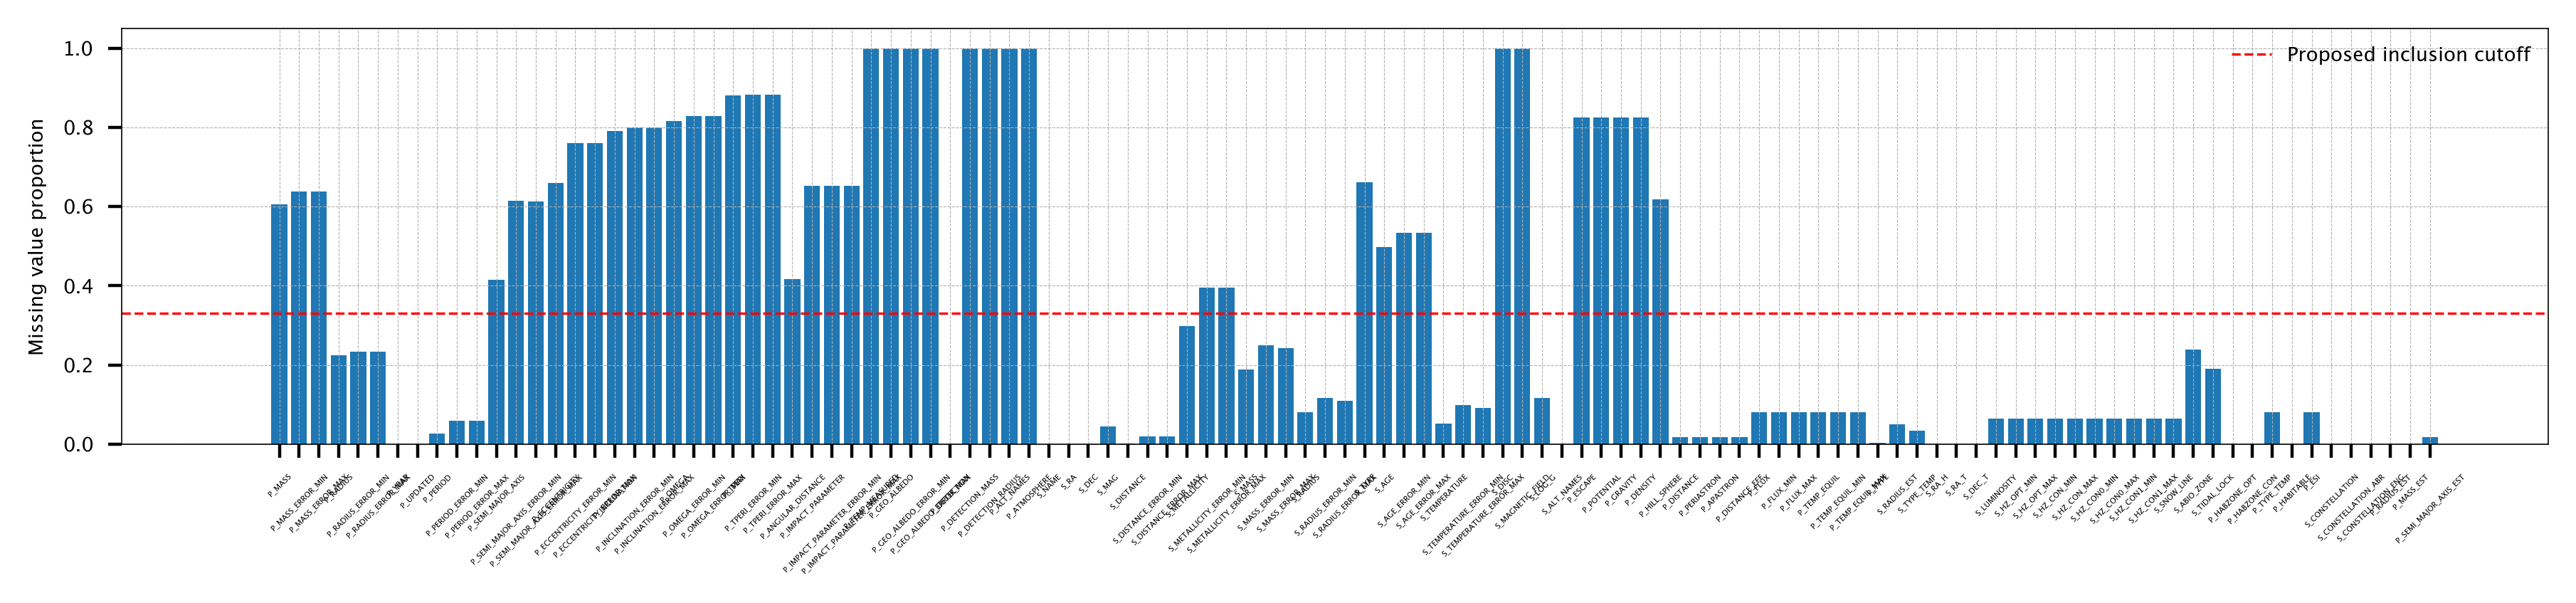

In [257]:
plt.figure(figsize=(11, 2))
plt.bar(range(len(isna_prop)), isna_prop)
plt.grid(linestyle='--', linewidth=.2)
plt.xticks(range(len(isna_prop))[2:], planet_df.columns[2:], fontsize=2, rotation=45)
plt.ylabel('Missing value proportion', fontsize=5)
plt.subplots_adjust(bottom=0.15)
plt.axhline(np.mean(isna_prop), color='red', linestyle='--', linewidth=0.6, label='Proposed inclusion cutoff')
plt.legend(loc='upper right', ncol=1, frameon=False, markerscale=0, fontsize=5)
plt.show()

In [531]:
planet_df = planet_df.loc[:, cutoff_mask]

In [533]:
#remove columns that have minima and maxima of corresponding columns
planet_df = planet_df.loc[:, ~planet_df.columns.str.contains('MIN|MAX')]

0    0.986413
2    0.008399
1    0.005188
Name: P_HABITABLE, dtype: float64


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

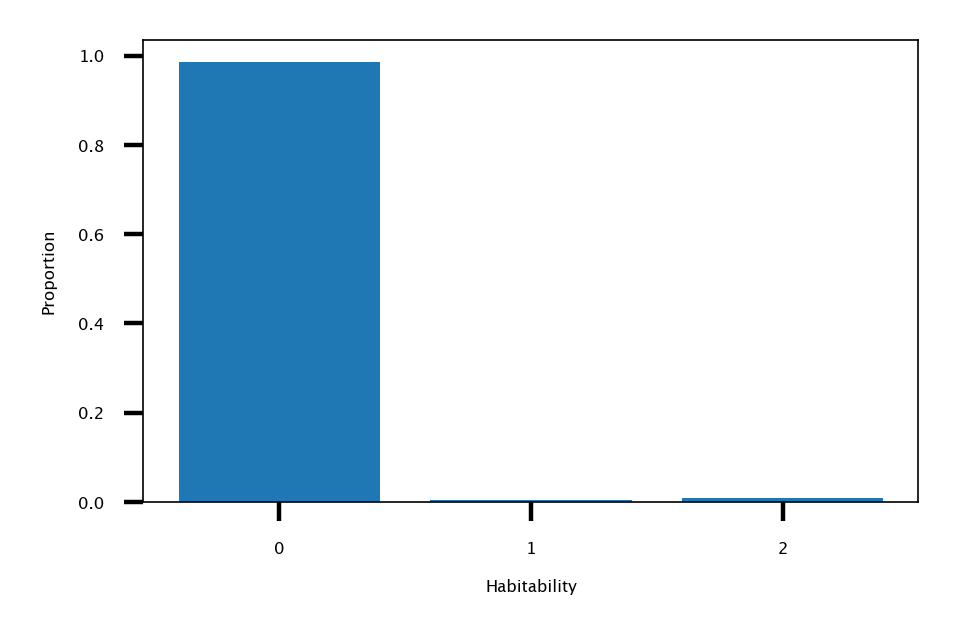

In [535]:
#habitability value counts
habitability_prop = planet_df['P_HABITABLE'].value_counts(normalize=True)
print(habitability_prop)
plt.bar(habitability_prop.index, habitability_prop)
plt.ylabel('Proportion',  fontsize=3)
plt.xlabel('Habitability', fontsize=3)
plt.xticks([0, 1, 2], size=3)
plt.yticks(size=3)

In [536]:
#For the unhabitable planets, delete observations with missing attributes 
planet_df_test = planet_df.copy()
N = len(planet_df_test)
Filter_mask = [True for i in range(N)]

for i in range(N):
    if planet_df_test.iloc[i, :]['P_HABITABLE'] == 0 and planet_df_test.iloc[i, :].isna().any():
        Filter_mask[i] = False

print(f'Number of resulting overall observations: {np.sum(Filter_mask)}')
print(f'New proportion in terms of habitability categories:')
print(planet_df[Filter_mask]["P_HABITABLE"].value_counts(normalize=False))
print('-------------------------------------------')
print(f'Orginal proportion in terms of habitability categories:')
print(planet_df["P_HABITABLE"].value_counts(normalize=False))

Number of resulting overall observations: 2104
New proportion in terms of habitability categories:
0    2049
2      34
1      21
Name: P_HABITABLE, dtype: int64
-------------------------------------------
Orginal proportion in terms of habitability categories:
0    3993
2      34
1      21
Name: P_HABITABLE, dtype: int64


In [537]:
#declare the row-reduced main planet dataframe
planet_df = planet_df[Filter_mask]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


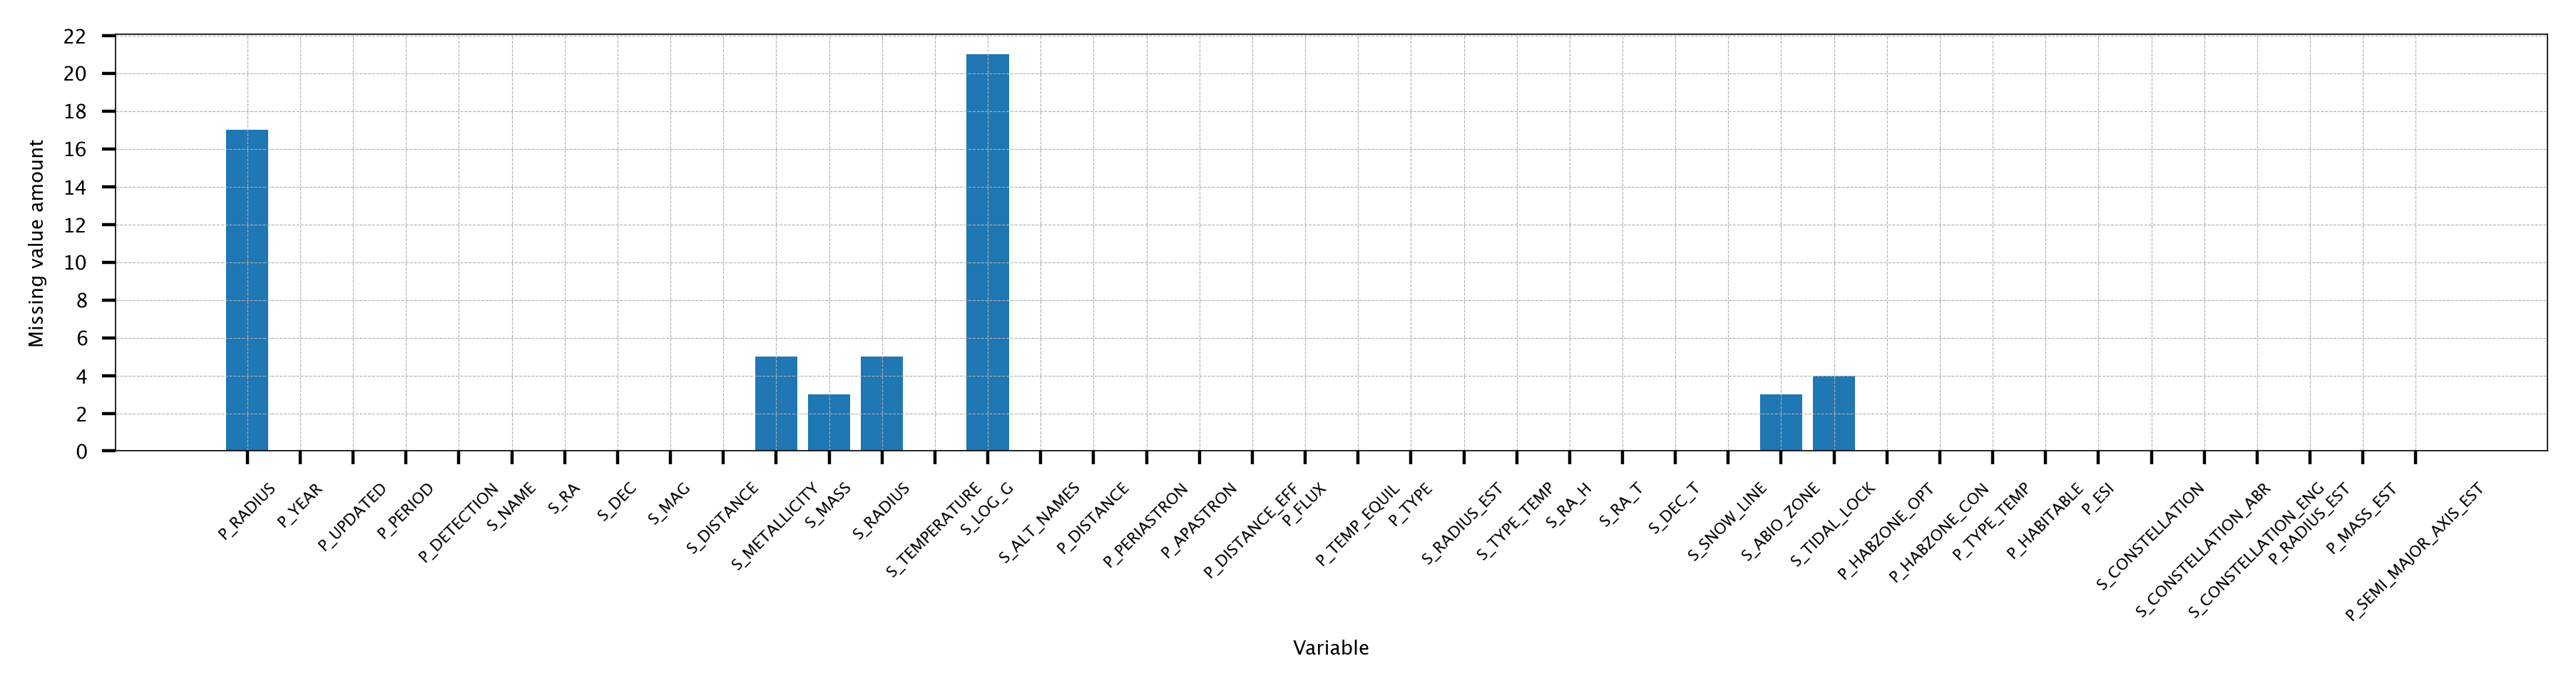

In [538]:
#plot of columns in dataset after preliminary cleaning
plt.figure(figsize=(11, 2))
plt.bar(range(len(planet_df.isna().mean()))[2:], planet_df.isna().sum()[2:])
plt.grid(linestyle='--', linewidth=.2)
plt.xticks(range(len(planet_df.isna().mean()))[2:], planet_df.columns[2:], fontsize=4, rotation=45)
plt.yticks(np.arange(0, 24, 2))
plt.ylabel('Missing value amount', fontsize=5)
plt.xlabel('Variable', fontsize=5)
plt.subplots_adjust(bottom=0.15)
#plt.axhline(np.mean(isna_prop), color='red', linestyle='--', linewidth=0.6, label='Proposed inclusion cutoff')
plt.legend(loc='right', ncol=1, frameon=False, markerscale=0, fontsize=5)
plt.show()

In [496]:
def Descriptives(df: pd.DataFrame) -> pd.DataFrame:
    """Generates a dataframe with several descriptive statistics."""

    cols = df.columns

    index = ['count', 'mu', 'sigma', 'kur', 'skew',  'JB', 'min', 'max']
    df_stats = pd.DataFrame(index)

    for i in cols:
        count = len(df[i])
        mu = float(np.mean(df[i]))
        sigma = float(np.std(df[i]))
        kur = float(stats.kurtosis(df[i]))
        skew = float(stats.skew(df[i]))
        JB = stats.jarque_bera(df[i])[1]
        minimum = float(np.min(df[i]))
        maximum = float(np.max(df[i]))
        new_df = np.around(pd.DataFrame([count, mu, sigma, kur, skew, JB, minimum, maximum ]), 3)
        df_stats = pd.concat([df_stats, new_df], axis= 1)
    
    df_stats.index = index
    df_stats = df_stats.iloc[:, 1:]
    df_stats.columns = cols

    return df_stats

In [539]:
#Descriptive stats after preliminary clearning:
print(Descriptives(planet_df[cols_interest]).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  S\_TEMPERATURE &  P\_TEMP\_EQUIL &  S\_RADIUS\_EST &  S\_SNOW\_LINE &     P\_ESI &  P\_RADIUS\_EST \\
\midrule
count &       2104.000 &      2104.000 &      2104.000 &     2104.000 &  2104.000 &      2104.000 \\
mu    &       5495.468 &       915.026 &         1.039 &        2.746 &     0.265 &         4.497 \\
sigma &        723.547 &       442.356 &         0.424 &        1.557 &     0.140 &         4.864 \\
kur   &          2.356 &         0.696 &        21.050 &        9.010 &     3.497 &         2.782 \\
skew  &         -0.792 &         0.766 &         2.995 &        1.812 &     1.247 &         1.812 \\
JB    &          0.000 &         0.000 &         0.000 &        0.000 &     0.000 &         0.000 \\
min   &       2559.000 &       133.922 &         0.110 &        0.064 &     0.025 &         0.336 \\
max   &      10170.000 &      3701.097 &         6.300 &       19.727 &     0.931 &        39.796 \\
\bottomrule
\end{tabular}



/var/folders/sr/ttxsgn1x77d0_dm9kv1l52l40000gn/T/ipykernel_74269/3538123624.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Descriptives(planet_df[cols_interest]).to_latex())


Suspected non-meaningful variables:
- P_NAME
- P_STATUS
- S_NAME
- S_ALT_NAMES
- P_YEAR 
- P_UPDATED
- S_RA_T
- S_RA_H
- S_DEC_T
- S_CONSTELLATION
- S_CONSTELLATION_ABR

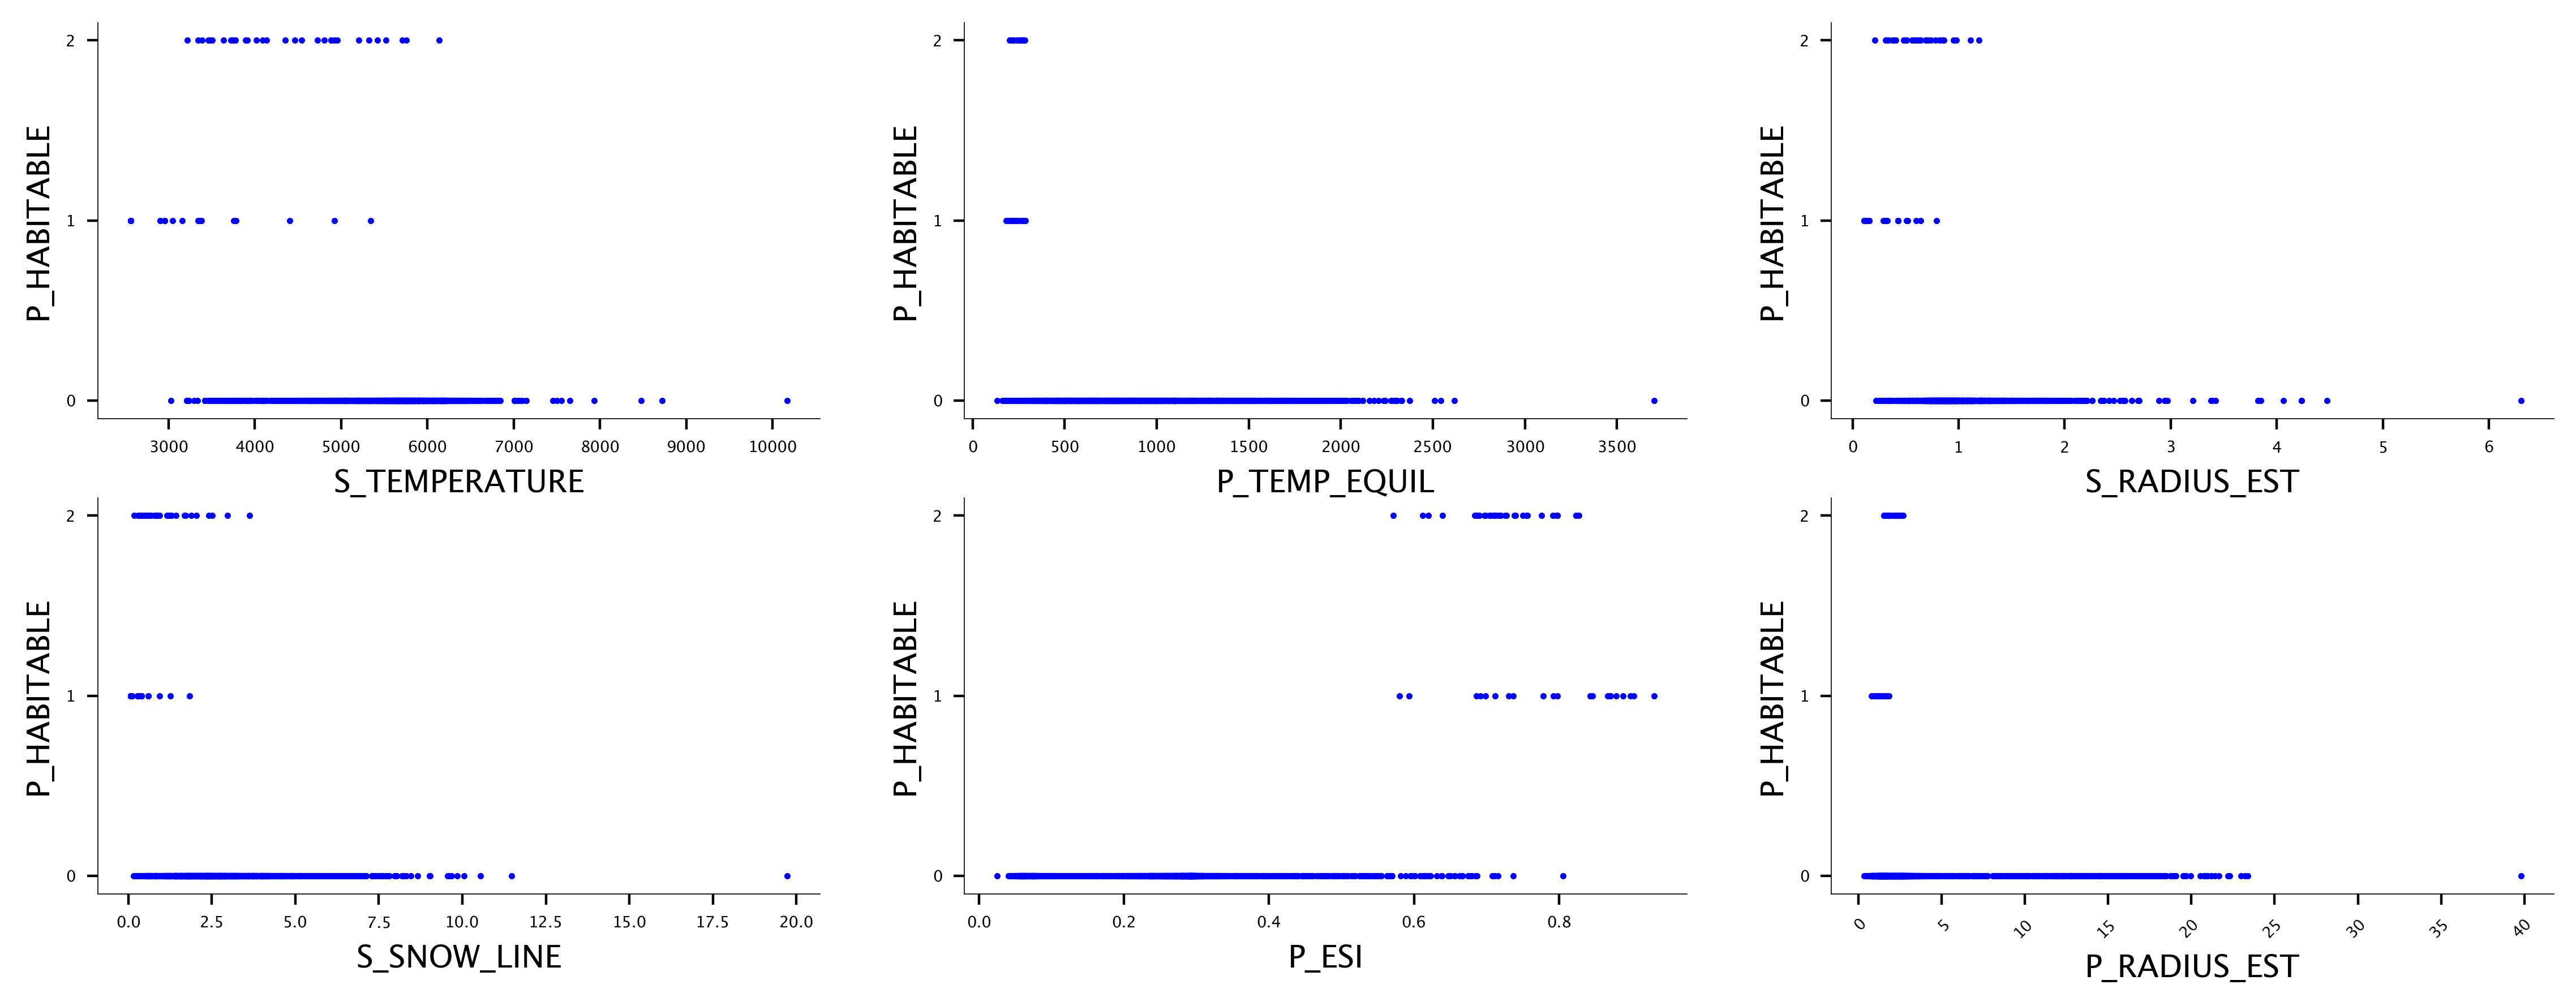

In [380]:
#filter out columns that are 100% complete:
planet_df_complete = planet_df.loc[:, planet_df.isna().sum() == 0]

#exclude meaningless variables for our purposes:
exclude_variables = ['P_NAME', 'P_STATUS', 'S_NAME', 'S_ALT_NAMES', 'P_YEAR', 'P_UPDATED', 'S_RA_H', 'S_RA_T', 'S_DEC_T', 'S_CONSTELLATION', 'S_CONSTELLATION_ABR']
exlc_mask = np.logical_not(planet_df_complete.columns.isin(exclude_variables))
planet_df_complete = planet_df_complete.loc[:, exlc_mask]

#for the following plot we include only columnns that have a high enough correlation with out varuables of interest
cols = planet_df_complete.columns
cols_interest = []
for i in range(len(cols)):
    if planet_df_complete[cols[i]].dtype == "float64":
        if abs(planet_df_complete.P_HABITABLE.corr(planet_df_complete[cols[i]])) > 0.4 or abs(planet_df_complete.P_ESI.corr(planet_df_complete[cols[i]])) > 0.4:
            cols_interest.append(cols[i])
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 5))  # adjust nrows and ncols as needed
axes = axes.flatten()

cols = list(planet_df_complete.columns)
cols.remove('P_HABITABLE')

cols_interest 

for i in range(len(cols_interest)):
    ax = axes[i]
    ax.scatter(planet_df_complete[cols_interest[i]], planet_df_complete['P_HABITABLE'], s=1, color='blue')
    ax.set_xlabel(cols_interest[i])
    ax.set_ylabel('P_HABITABLE')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks([0, 1, 2])
# rotate x-axis tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
#plt.tight_layout()
plt.show()

## $\text{Data cleaning:}$

In [540]:
#exclude meaningless variables: ADD SOMETHING ABOUT CORRELATION S_RA etc.
exclude_variables = ['P_STATUS', 'S_NAME', 'S_ALT_NAMES', 'P_YEAR', 'P_UPDATED', 'S_RA_H', 'S_RA_T', 'S_DEC_T', 'S_CONSTELLATION', 'S_CONSTELLATION_ABR']
exlc_mask = np.logical_not(planet_df.columns.isin(exclude_variables))
planet_df_clean = planet_df.loc[:, exlc_mask]

$ \text{Missing values imputation:}$

In [541]:
#convert categorial variables into floats, being kind of the first feature engineering step as well
planet_df_clean = planet_df_clean.reset_index(drop = True)
planet_df_clean_conv = planet_df_clean.copy()

cat_cols = list(planet_df_clean.select_dtypes(include=['object']).columns)[1:]

for i in cat_cols:
    le = LabelEncoder()
    planet_df_clean_conv[i] = le.fit_transform(planet_df_clean_conv[i].astype(str))
    planet_df_clean_conv[i] = planet_df_clean_conv[i].astype(float)


In [545]:
#comparing and checking the category labels for e.g. detection method variable
# print(set(planet_df_clean_conv.P_TYPE))
# print(set(planet_df_clean.P_TYPE))

# #!!:
# print(set(planet_df_clean_conv.S_CONSTELLATION_ENG))
# print(set(planet_df_clean.S_CONSTELLATION_ENG))

In [542]:
#mode imputation
mode_imp = SimpleImputer(strategy='most_frequent')
planet_df_mode_imp = mode_imp.fit_transform(planet_df_clean)

#KNN imputation
knn_imp = KNNImputer(n_neighbors=5)
planet_df_knn_imp = knn_imp.fit_transform(planet_df_clean_conv.drop('P_NAME', axis = 1))

In [543]:
#FINAL MODE IMPUTED DATASET:
planet_df_mode_imp = pd.DataFrame(planet_df_mode_imp, columns=(planet_df_clean.columns))

In [544]:
#FINAL KNN IMPUTED DATASET:
planet_df_knn_imp = pd.DataFrame(planet_df_knn_imp, columns=(planet_df_clean.drop('P_NAME', axis = 1).columns))
planet_df_knn_imp['P_NAME'] = planet_df_clean_conv['P_NAME']

In [26]:
planet_df['P_HABITABLE'].value_counts(normalize=False)

0    2049
2      34
1      21
Name: P_HABITABLE, dtype: int64

In [ ]:
#WE COMBINE THE TWO HABITABLE CLASSES INTO ONE AND COMBINING THE HABZONE VARIABLE:
planet_df_binary = planet_df_knn_imp.copy()
for i in range(len(planet_df_binary)):
    if planet_df_binary['P_HABITABLE'][i] == 1 or planet_df_binary['P_HABITABLE'][i] == 2:
        planet_df_binary['P_HABITABLE'][i] = 1

planet_df_binary['HABZONE'] =  (planet_df_binary['P_HABZONE_CON'] + planet_df_binary['P_HABZONE_OPT']).astype(int)
planet_df_binary = planet_df_binary.drop('P_HABZONE_CON', axis = 1)
planet_df_binary = planet_df_binary.drop('P_HABZONE_OPT', axis = 1)

#check:
print(np.max(planet_df_binary['P_HABITABLE']))
print(np.sum(planet_df_binary['P_HABITABLE']))

In [28]:
planet_df_binary

,P_RADIUS,P_PERIOD,P_DETECTION,S_RA,S_DEC,S_MAG,S_DISTANCE,S_METALLICITY,S_MASS,S_RADIUS,...,S_TIDAL_LOCK,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST,P_NAME,HABZONE
0,1.905700,0.736539,1.0,133.149220,28.330818,5.960,12.59,0.31,0.91,0.940000,...,0.510511,1.0,0.0,0.259897,11.0,1.905700,8.079188,0.015440,55 Cnc e,0
1,2.578300,41.685500,2.0,53.650967,20.599232,11.038,180.39,-0.15,1.67,1.080000,...,0.547339,1.0,0.0,0.307962,7.0,2.578300,22.247960,0.279086,BD+20 594 b,0
2,16.702900,1.508956,2.0,102.079890,-3.102147,13.600,805.31,-0.30,0.95,1.110000,...,0.453516,1.0,0.0,0.055288,67.0,16.702900,327.362840,0.025305,CoRoT-1 b,0
3,10.873700,13.240600,2.0,291.063710,0.746143,15.220,345.00,0.26,0.89,0.790000,...,0.413246,1.0,0.0,0.107056,18.0,10.873700,874.027010,0.105500,CoRoT-10 b,0
4,16.030300,2.994330,2.0,280.687260,5.937688,12.939,560.00,-0.03,1.27,1.370000,...,0.434842,1.0,0.0,0.057585,56.0,16.030300,740.539250,0.043600,CoRoT-11 b,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2.040220,6.267900,2.0,84.291214,-80.469124,5.670,18.28,0.08,1.09,1.100000,...,0.441641,1.0,0.0,0.256979,63.0,2.040220,4.821451,0.068390,pi Men c,0
2100,2.188192,162.870000,1.0,26.017012,-15.937480,3.500,3.60,-0.55,0.78,0.793000,...,0.441395,2.0,1.0,0.737081,71.0,1.809973,3.931532,0.538000,tau Cet e,1
2101,1.870000,28.165600,2.0,179.705920,-3.389389,14.900,160.00,0.00,0.41,0.374241,...,0.369679,2.0,1.0,0.755038,68.0,1.870000,4.155456,0.134560,K2-296 b,1
2102,1.703920,6.689000,1.0,53.998749,-44.512703,13.060,3.69,-0.08,0.12,0.156000,...,0.244044,2.0,1.0,0.879042,46.0,1.178333,1.750000,0.035000,GJ 1061 c,1


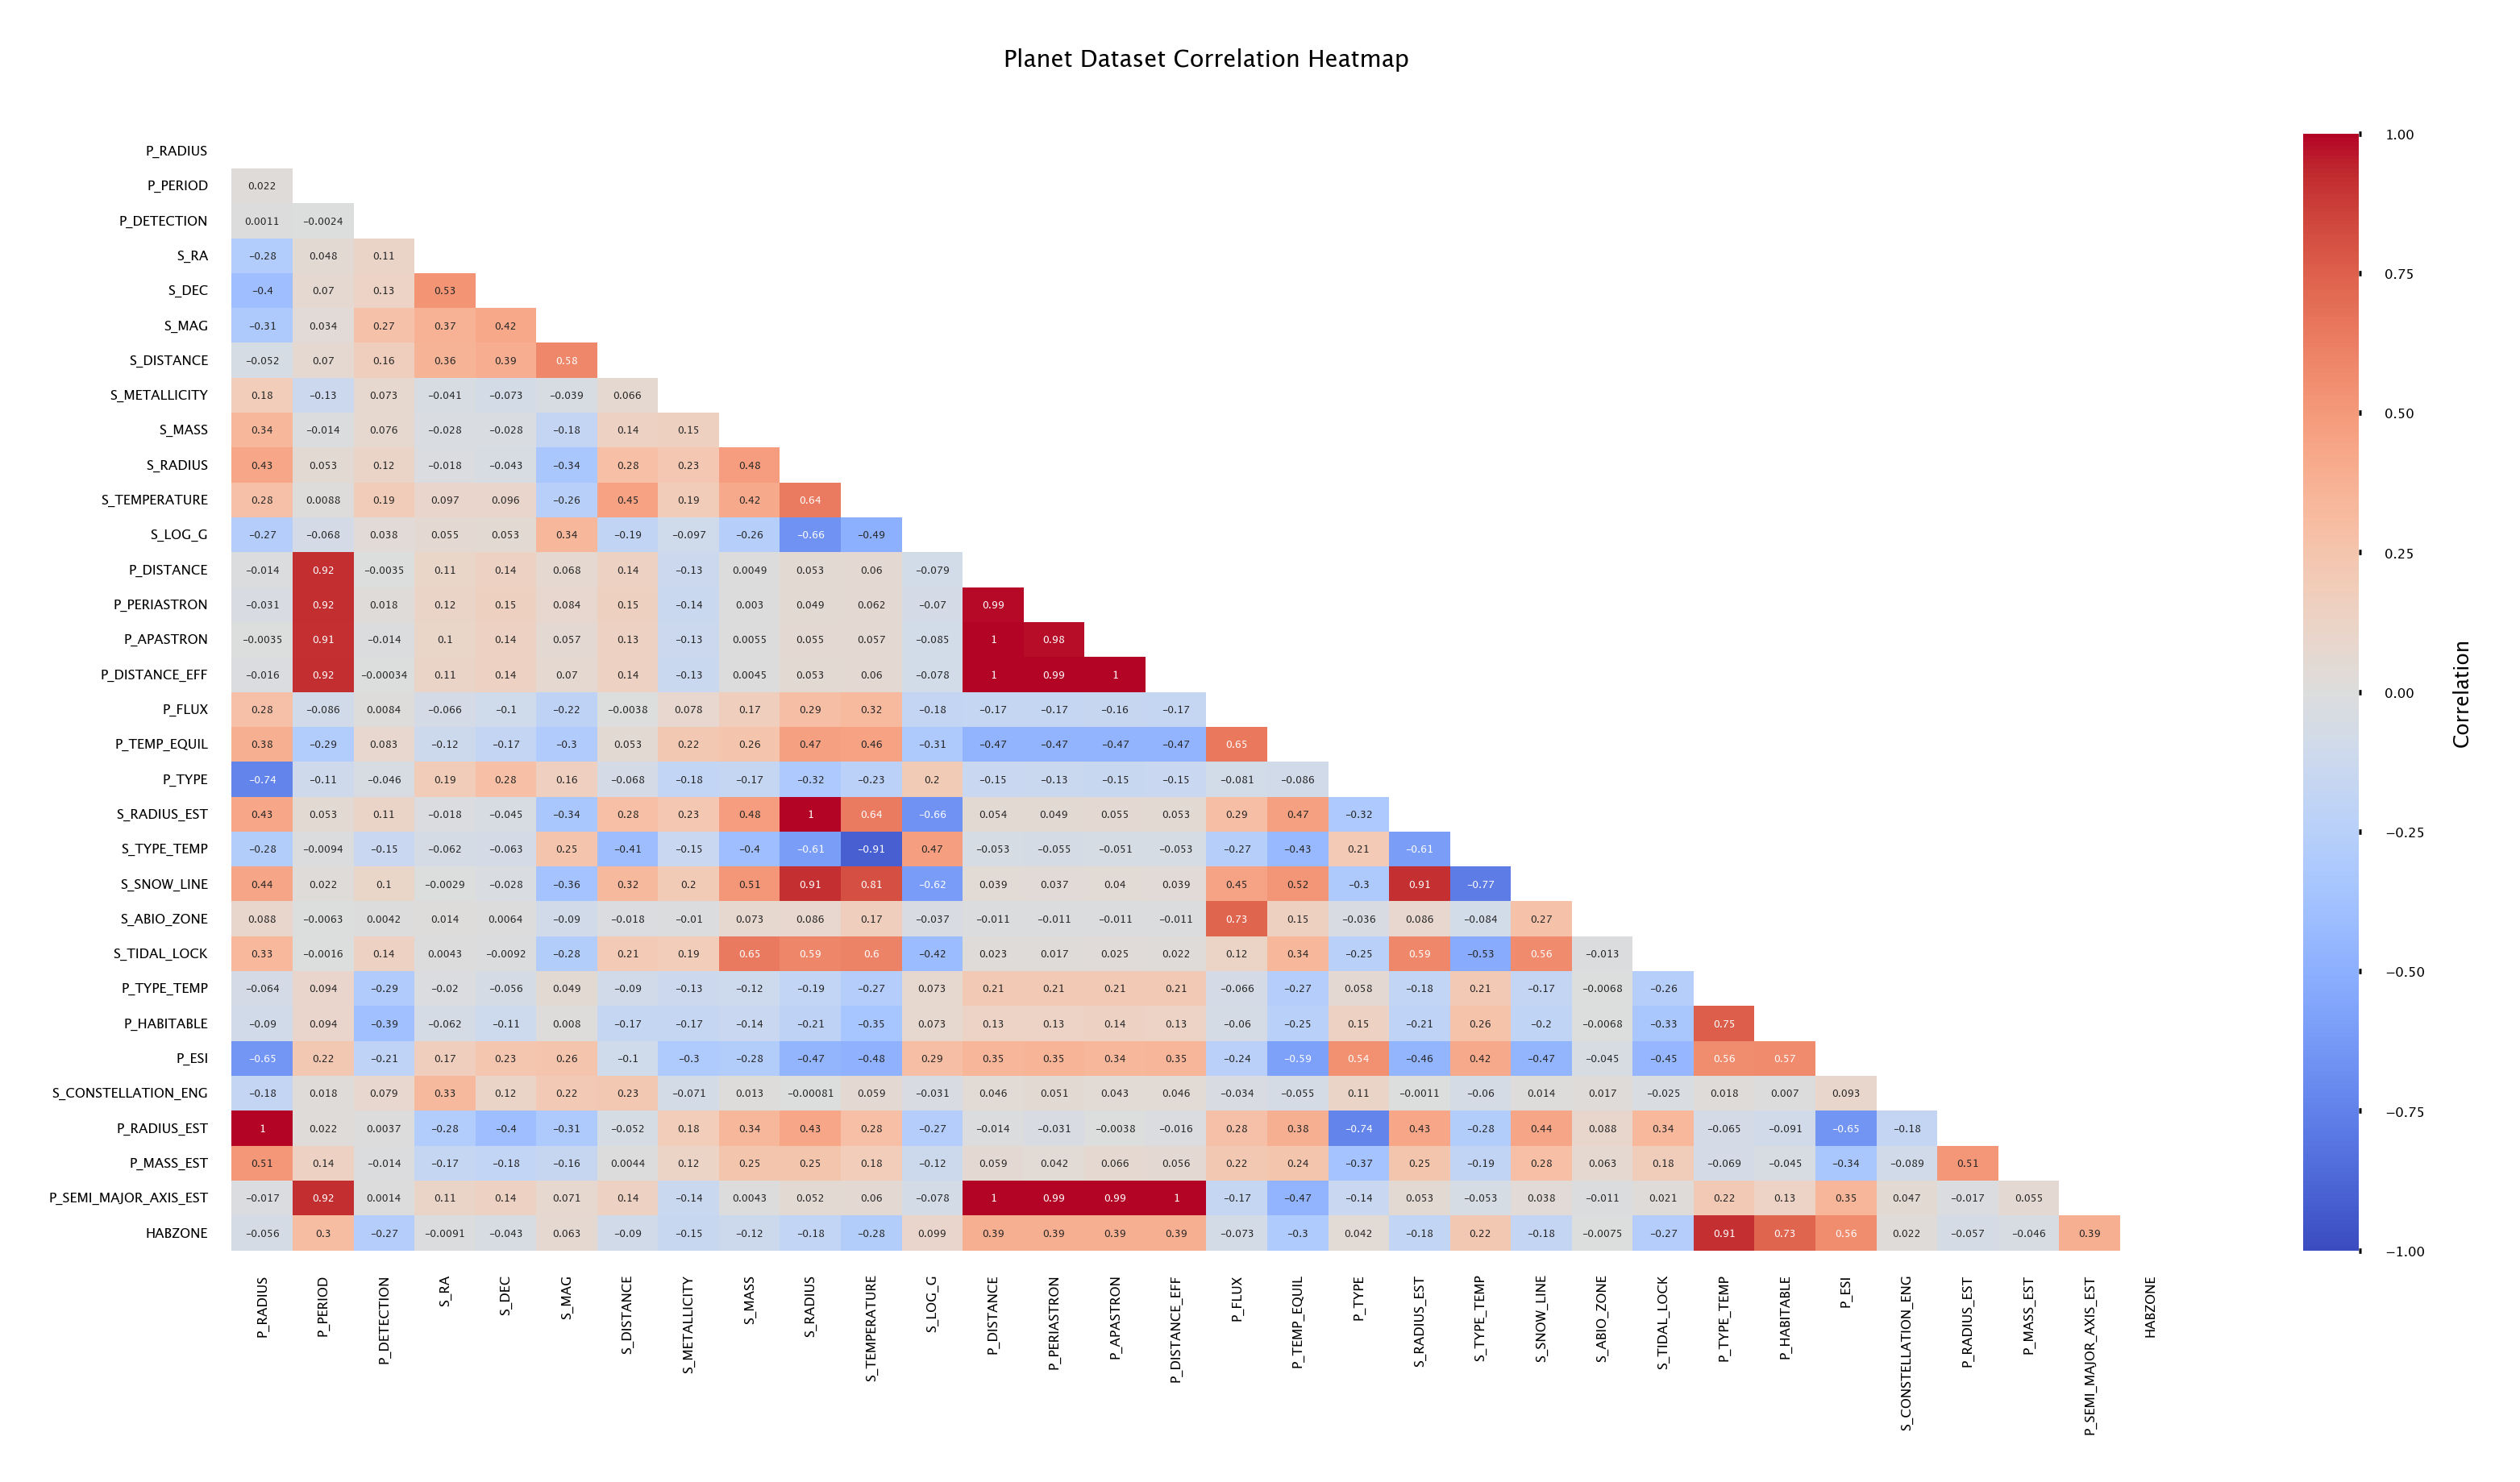

In [548]:
#Solving Multicollinearity: corr heatmap:
fig, ax1 = plt.subplots(figsize=(6.5,3), dpi = 600)
numerical_mask = planet_df_binary.select_dtypes(include=[np.number]).columns.tolist()
planet_corr = planet_df_binary[numerical_mask].corr()

tr_mask = np.triu(np.ones_like(planet_corr, dtype=bool))
heatmap = sns.heatmap(planet_corr, mask=tr_mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":1.5}, 
    cmap='coolwarm', cbar_kws={'label': 'Correlation'}, xticklabels=True, yticklabels=True, ax=ax1)

heatmap.set_title('Planet Dataset Correlation Heatmap', fontdict={'fontsize':3.5}, pad=10)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=2) 
heatmap.set_yticklabels(heatmap.get_yticklabels(),fontsize=2)
heatmap.tick_params(size=0.0)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=2)
cbar.ax.tick_params(size=0.4)

heatmap.figure.axes[-1].yaxis.label.set_size(3)

In [ ]:
#Use the VARIANCE INFLATION FACTOR (VIF) method to assess multicollinearity
df = planet_df_binary.drop('P_NAME', axis = 1)

#create a list of column names to check for multicollinearity
cols = list(df.columns)

#initialize a flag variable to keep track of whether multicollinearity exists
multicollinearity = True

while multicollinearity:
    #calculate the VIF for each column
    vif = [variance_inflation_factor(df[cols].values, i) for i in range(len(cols))]
    
    #find the column with the highest VIF value
    max_vif = max(vif)
    max_vif_idx = vif.index(max_vif)
    
    #if the highest VIF is above the threshold, remove that column from the list of columns
    if max_vif > 5:
        cols.pop(max_vif_idx)
    else:
        #if all VIF values are below the threshold, set the flag variable to False to exit the loop
        multicollinearity = False

#create a new DataFrame with only the columns that passed the multicollinearity test
df_no_multicollinearity = df[cols]

In [560]:
print(Descriptives(df_no_multicollinearity).drop(['P_TYPE', 'P_HABITABLE', 'HABZONE'], axis = 1).to_latex())

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  P\_RADIUS &  P\_PERIOD &     S\_DEC &  S\_DISTANCE &  S\_METALLICITY &    S\_MASS &     P\_FLUX &  S\_ABIO\_ZONE &  P\_MASS\_EST \\
\midrule
count &  2104.000 &  2104.000 &  2104.000 &    2104.000 &       2104.000 &  2104.000 &   2104.000 &     2104.000 &    2104.000 \\
mu    &     4.499 &    29.400 &    31.244 &     642.928 &          0.011 &     0.988 &    492.906 &        5.068 &     105.574 \\
sigma &     4.863 &   111.476 &    25.696 &     412.159 &          0.146 &     0.561 &   1335.213 &      114.285 &     371.853 \\
kur   &     2.784 &   557.501 &     2.203 &       0.816 &          2.098 &  1243.637 &    567.270 &     2063.273 &      79.417 \\
skew  &     1.812 &    19.657 &    -1.736 &       0.741 &         -0.361 &    31.135 &     18.536 &       45.272 &       7.579 \\
JB    &     0.000 &     0.000 &     0.000 &       0.000 &          0.000 &     0.000 &      0.000 &        0.000 &       0.000 \\
min   &     0.336 &     0.180 &   -8

/var/folders/sr/ttxsgn1x77d0_dm9kv1l52l40000gn/T/ipykernel_74269/2123008953.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(Descriptives(df_no_multicollinearity).drop(['P_TYPE', 'P_HABITABLE', 'HABZONE'], axis = 1).to_latex())


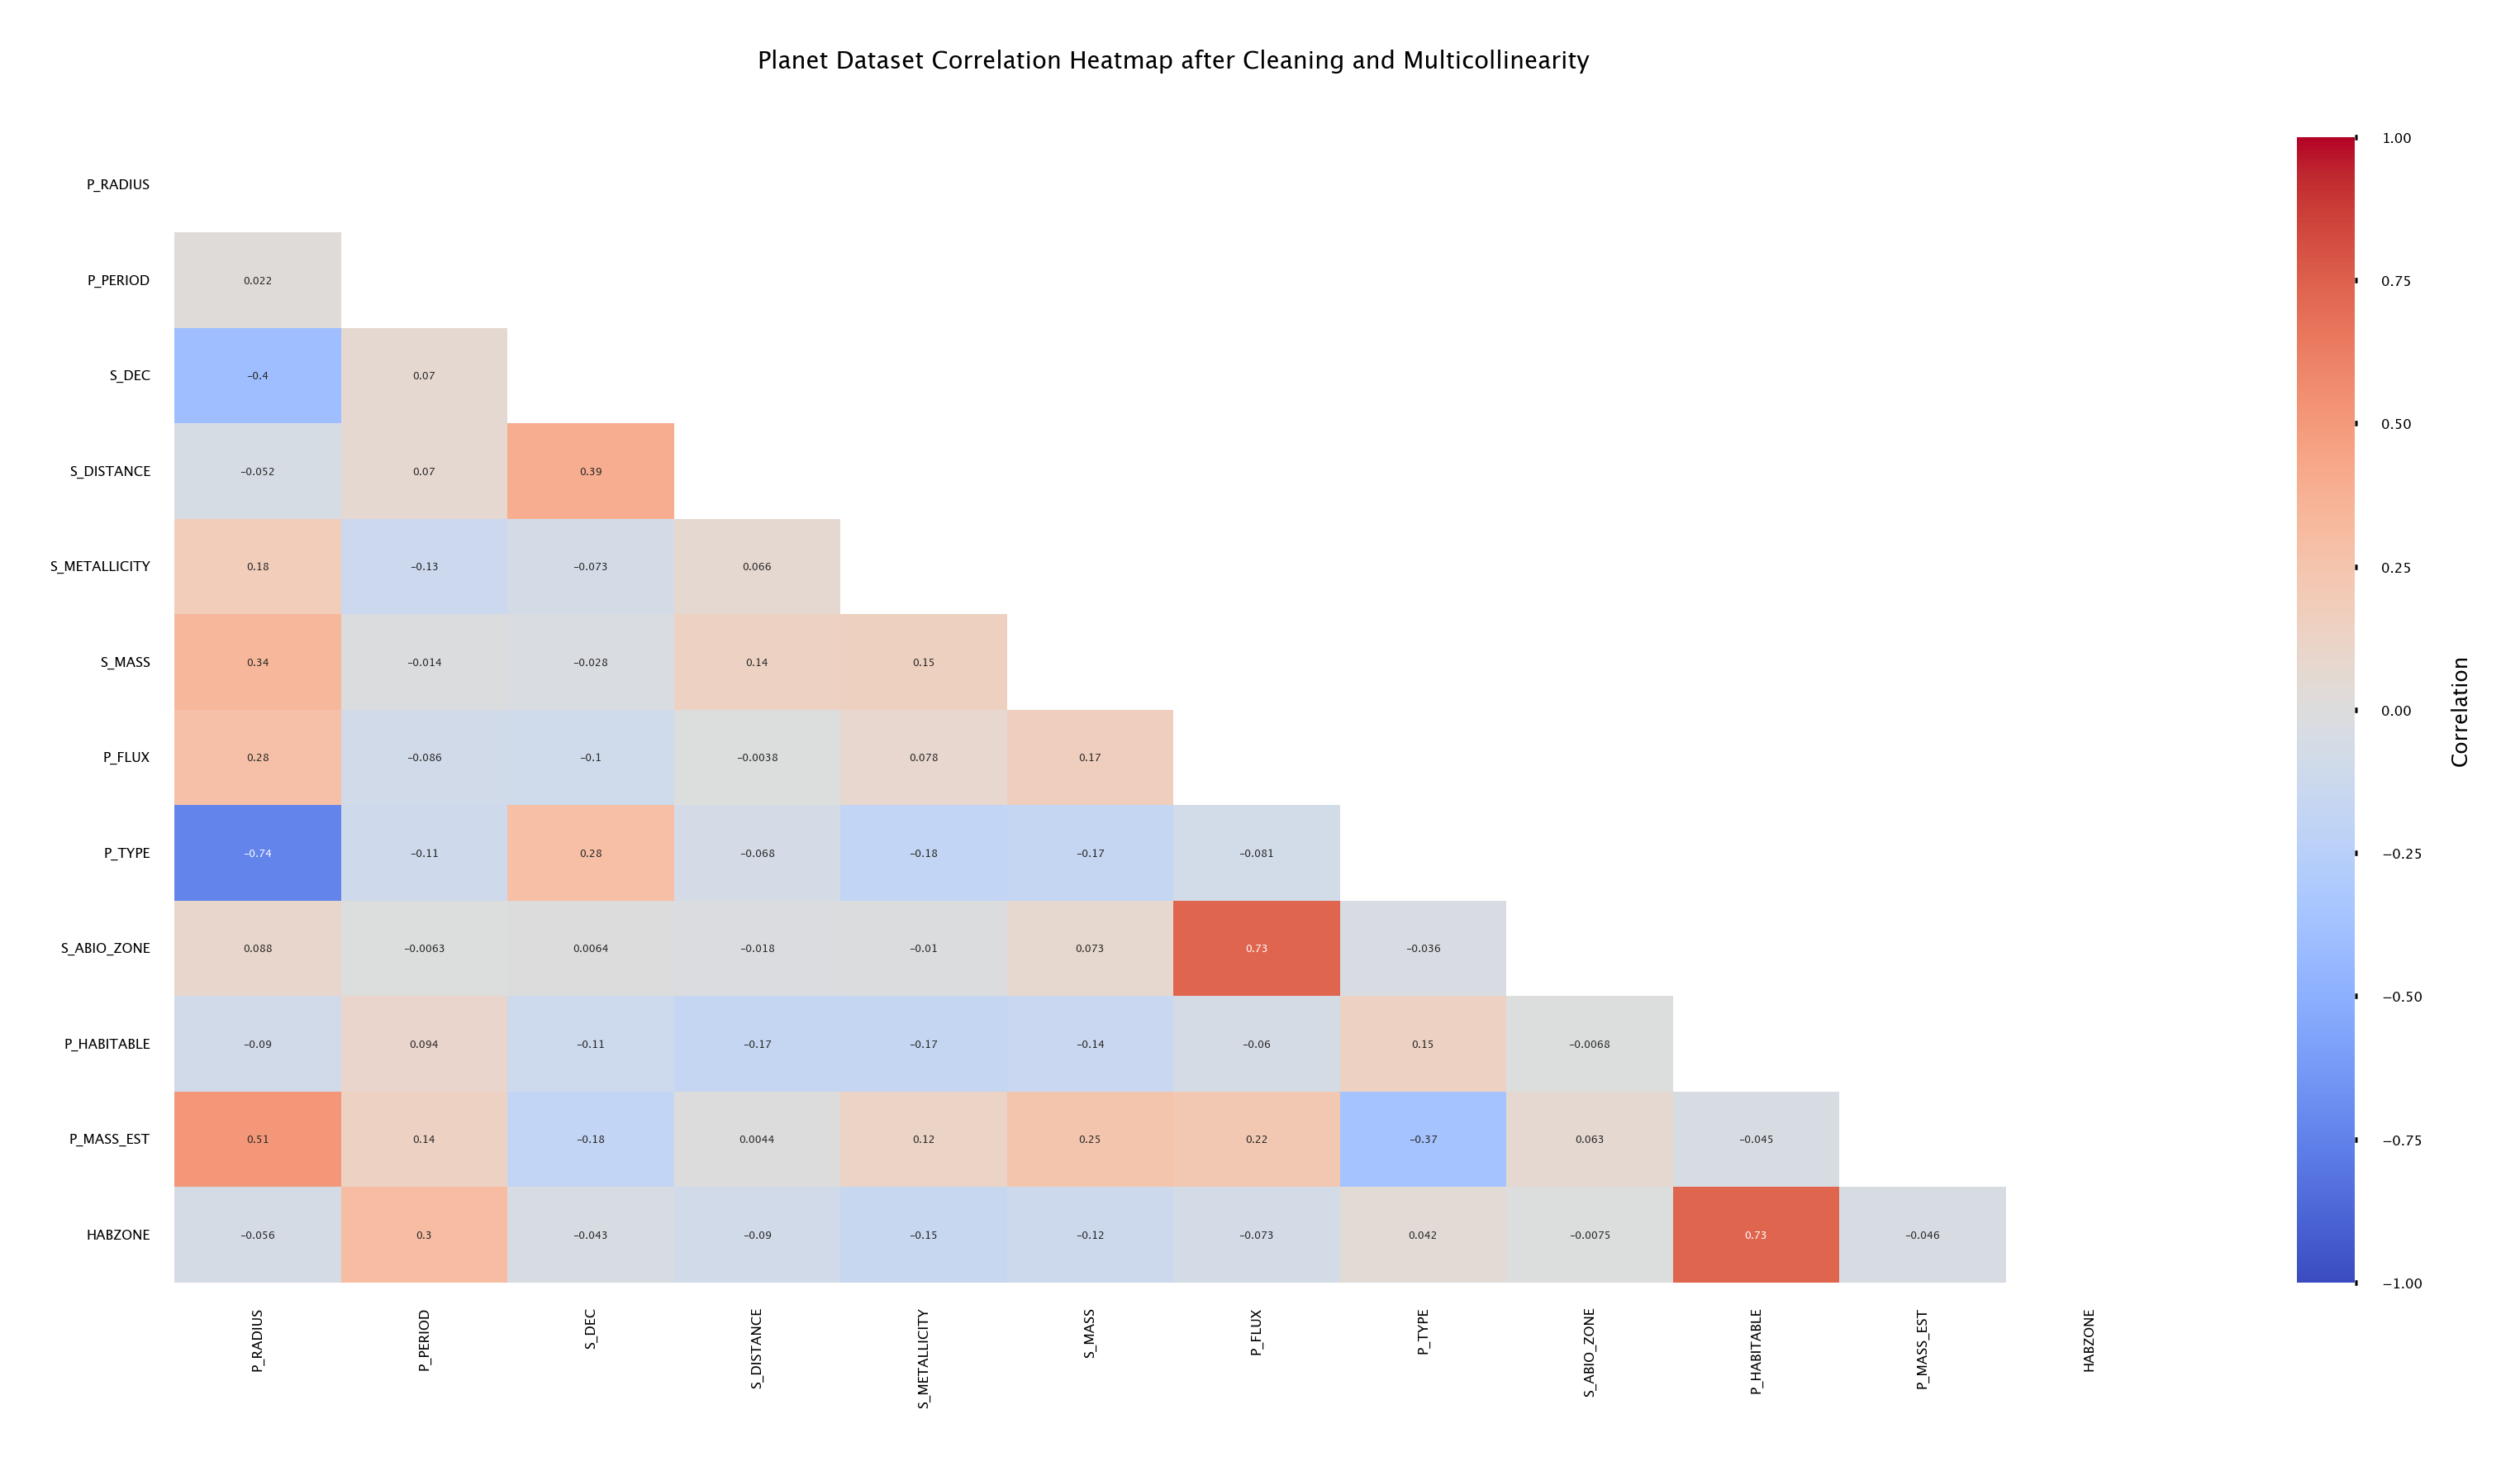

In [549]:
fig, ax1 = plt.subplots(figsize=(6.5,3), dpi = 600)

planet_corr = df_no_multicollinearity.corr()

tr_mask = np.triu(np.ones_like(planet_corr, dtype=bool))
heatmap = sns.heatmap(planet_corr, mask=tr_mask, vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":1.5}, 
    cmap='coolwarm', cbar_kws={'label': 'Correlation'}, xticklabels=True, yticklabels=True, ax=ax1)

heatmap.set_title('Planet Dataset Correlation Heatmap after Cleaning and Multicollinearity', fontdict={'fontsize':3.5}, pad=10)
heatmap.set_xticklabels(heatmap.get_xticklabels(),fontsize=2) 
heatmap.set_yticklabels(heatmap.get_yticklabels(),fontsize=2)
heatmap.tick_params(size=0.0)

cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=2)
cbar.ax.tick_params(size=0.4)

heatmap.figure.axes[-1].yaxis.label.set_size(3)

In [ ]:
#Change the catogorical variables into integer type:
df_no_multicollinearity.P_TYPE = df_no_multicollinearity.P_TYPE.astype(int)
df_no_multicollinearity.P_HABITABLE = df_no_multicollinearity.P_HABITABLE.astype(int)

In [34]:
df_no_multicollinearity.dtypes

P_RADIUS         float64
P_PERIOD         float64
S_DEC            float64
S_DISTANCE       float64
S_METALLICITY    float64
S_MASS           float64
P_FLUX           float64
P_TYPE             int64
S_ABIO_ZONE      float64
P_HABITABLE        int64
P_MASS_EST       float64
HABZONE            int64
dtype: object

In [35]:
df_no_multicollinearity

,P_RADIUS,P_PERIOD,S_DEC,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_TYPE,S_ABIO_ZONE,P_HABITABLE,P_MASS_EST,HABZONE
0,1.905700,0.736539,28.330818,12.59,0.31,0.91,2420.618400,3,0.723308,0,8.079188,0
1,2.578300,41.685500,20.599232,180.39,-0.15,1.67,14.830572,1,2.357775,0,22.247960,0
2,16.702900,1.508956,-3.102147,805.31,-0.30,0.95,2160.722500,0,2.679932,0,327.362840,0
3,10.873700,13.240600,0.746143,345.00,0.26,0.89,39.299539,0,0.583211,0,874.027010,0
4,16.030300,2.994330,5.937688,560.00,-0.03,1.27,1521.599200,0,6.850910,0,740.539250,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2.040220,6.267900,-80.469124,18.28,0.08,1.09,307.874350,3,3.257894,0,4.821451,0
2100,2.188192,162.870000,-15.937480,3.60,-0.55,0.78,1.613943,4,0.885999,1,3.931532,1
2101,1.870000,28.165600,-3.389389,160.00,0.00,0.41,1.402963,3,0.048021,1,4.155456,1
2102,1.703920,6.689000,-44.512703,3.69,-0.08,0.12,1.353492,4,0.007807,1,1.750000,1


In [130]:
#save this csv file
df_no_multicollinearity.to_csv('FINAL_df_no_multicollinearity.csv', index=False)

#### $ \text{RESAMPLING \& SPLITTING DATA} $

In [36]:
planet_df_working = pd.concat([df_no_multicollinearity, planet_df_binary.P_ESI], axis=1)

In [37]:
planet_df_working

,P_RADIUS,P_PERIOD,S_DEC,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_TYPE,S_ABIO_ZONE,P_HABITABLE,P_MASS_EST,HABZONE,P_ESI
0,1.905700,0.736539,28.330818,12.59,0.31,0.91,2420.618400,3,0.723308,0,8.079188,0,0.259897
1,2.578300,41.685500,20.599232,180.39,-0.15,1.67,14.830572,1,2.357775,0,22.247960,0,0.307962
2,16.702900,1.508956,-3.102147,805.31,-0.30,0.95,2160.722500,0,2.679932,0,327.362840,0,0.055288
3,10.873700,13.240600,0.746143,345.00,0.26,0.89,39.299539,0,0.583211,0,874.027010,0,0.107056
4,16.030300,2.994330,5.937688,560.00,-0.03,1.27,1521.599200,0,6.850910,0,740.539250,0,0.057585
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2.040220,6.267900,-80.469124,18.28,0.08,1.09,307.874350,3,3.257894,0,4.821451,0,0.256979
2100,2.188192,162.870000,-15.937480,3.60,-0.55,0.78,1.613943,4,0.885999,1,3.931532,1,0.737081
2101,1.870000,28.165600,-3.389389,160.00,0.00,0.41,1.402963,3,0.048021,1,4.155456,1,0.755038
2102,1.703920,6.689000,-44.512703,3.69,-0.08,0.12,1.353492,4,0.007807,1,1.750000,1,0.879042


In [387]:
#SMOTE-ENN resampling method

#exclude the column P_ESI for classification problem 
planet_df_working_class = planet_df_working.drop('P_ESI', axis=1)

# Split your data into features (X) and target variable (y)
X = planet_df_working_class.drop('P_HABITABLE', axis=1)
y = planet_df_working_class['P_HABITABLE']

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) #Efe: 42

# Apply SMOTE-ENN
smote_enn = SMOTEENN(sampling_strategy='minority', random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Train a decision tree classifier on the resampled data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Evaluate the classifier on the test data
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       671
           1       0.96      0.96      0.96        24

    accuracy                           1.00       695
   macro avg       0.98      0.98      0.98       695
weighted avg       1.00      1.00      1.00       695



In [388]:
#define testing data:
planet_df_test = X_test
planet_df_test['P_HABITABLE'] = y_test

In [389]:
#new working dataset defined:
planet_df_resampled = X_train_resampled
planet_df_resampled['P_HABITABLE'] = y_train_resampled

In [390]:
#check resampled target variable's proportions --> approximately 50% each:
planet_df_resampled['P_HABITABLE'].value_counts(normalize=False)

1    1351
0    1319
Name: P_HABITABLE, dtype: int64

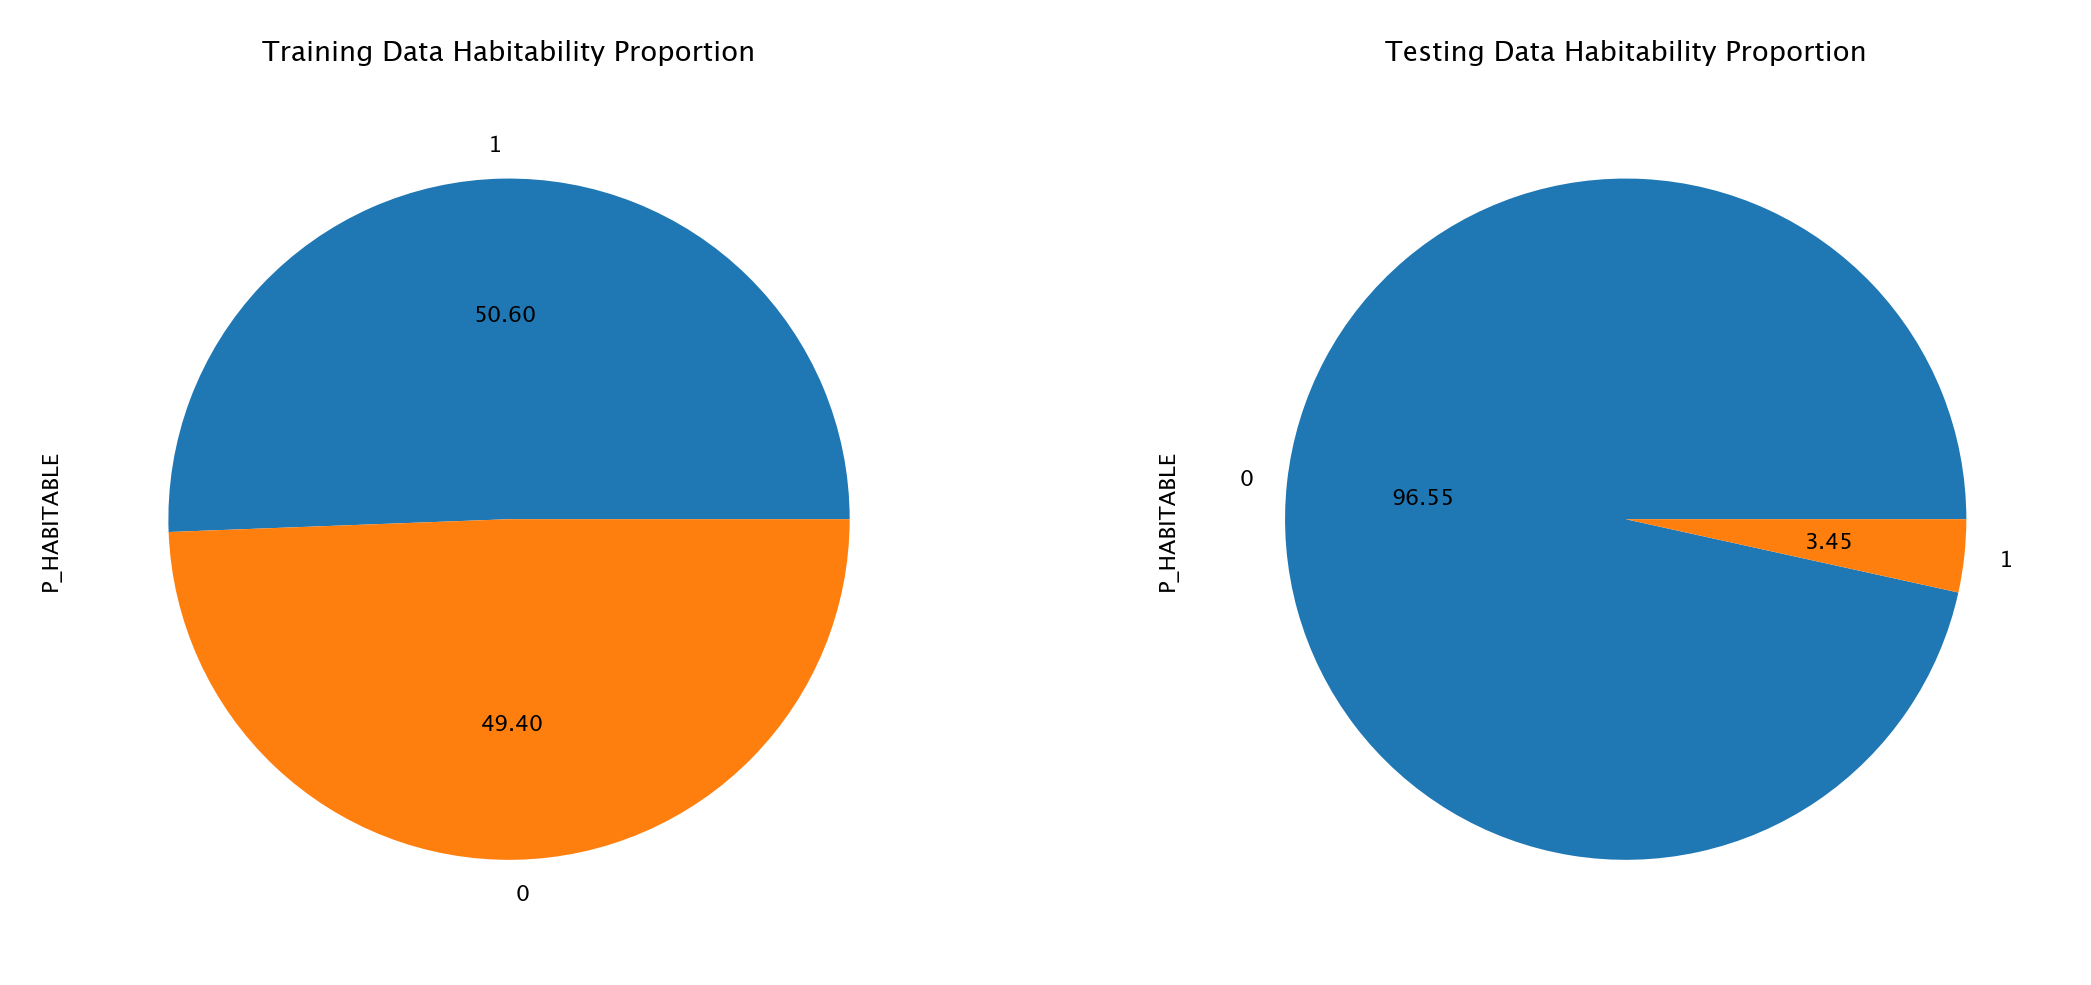

In [525]:
#Habitability proportion in testing dataset
# prop_plot = planet_df_test['P_HABITABLE'].value_counts().plot.pie(autopct='%.2f', fontsize=3)
# prop_plot.set_ylabel('P_HABITABLE', fontsize=4)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

#training data habitability proportion
prop_plot_train = planet_df_resampled['P_HABITABLE'].value_counts().plot.pie(ax=axes[0], autopct='%.2f', fontsize=4)
prop_plot_train.set_ylabel('P_HABITABLE', fontsize=4)
prop_plot_train.set_title('Training Data Habitability Proportion', fontsize=5)

#testing data habitability proportion
prop_plot = planet_df_test['P_HABITABLE'].value_counts().plot.pie(ax=axes[1], autopct='%.2f', fontsize=4)
prop_plot.set_ylabel('P_HABITABLE', fontsize=4)
prop_plot.set_title('Testing Data Habitability Proportion', fontsize=5)

# adjust layout and spacing between subplots
fig.tight_layout(pad=3.0)

# show the plot
plt.show()

In [137]:
# habitability_prop = planet_df_final_clean['P_HABITABLE'].value_counts(normalize=False)
# print(habitability_prop)
# plt.bar(habitability_prop.index, habitability_prop)
# plt.ylabel('Proportion',  fontsize=3)
# plt.xlabel('Habitability', fontsize=3)
# plt.xticks([0, 1], size=2)
# plt.yticks(size=3)

## $\text{Application of classification algorithms:}$

$ \text{K - Neighbours:}$

In [43]:
planet_df_resampled.dtypes

P_RADIUS         float64
P_PERIOD         float64
S_DEC            float64
S_DISTANCE       float64
S_METALLICITY    float64
S_MASS           float64
P_FLUX           float64
P_TYPE             int64
S_ABIO_ZONE      float64
P_MASS_EST       float64
HABZONE            int64
P_HABITABLE        int64
dtype: object

In [394]:
#For KNN: Need to scale all the numerical using minmax scaler
df_knn_train = planet_df_resampled.copy().sample(frac = 1).reset_index(drop = True)

def fRescaler(df, scaler = MinMaxScaler()):
    """Used to scale the continuous columns of the training data."""

    continuous_cols = df.select_dtypes(include=['float64']).columns #of training data subset
    categorical_cols = df.select_dtypes(include=['int64']).columns #of training data subset

    df_continuous = df[continuous_cols]
    df_categorical = df[categorical_cols]

    #rescale continuous variables for NN
    scaler.fit(df_continuous)
    X_scaled = scaler.transform(df_continuous)

    X_scaled_df = pd.DataFrame(X_scaled, columns=continuous_cols)
    cat_df = pd.DataFrame(df_categorical, columns=categorical_cols)

    X = pd.concat([X_scaled_df, cat_df], axis = 1)

    return X

In [395]:
#all necesseary subsets:
X_train_KNN = fRescaler(df_knn_train).drop('P_HABITABLE', axis = 1)
y_train_KNN = df_knn_train['P_HABITABLE']
X_test = X_test[X_train_KNN.columns].reset_index(drop = True)
#X_test.drop('P_HABITABLE', axis=1)
#y_test

### $\text{KNN CLASSFIFCATON}$

f1_score for test set 1 neigbor(s): 0.07999999999999999
accuracy of test score for 1 neigbors(s): 0.9669064748201439
--
f1_score for test set 2 neigbor(s): 0.07999999999999999
accuracy of test score for 2 neigbors(s): 0.9669064748201439
--
f1_score for test set 3 neigbor(s): 0.21428571428571427
accuracy of test score for 3 neigbors(s): 0.9683453237410072
--
f1_score for test set 4 neigbor(s): 0.21428571428571427
accuracy of test score for 4 neigbors(s): 0.9683453237410072
--
f1_score for test set 5 neigbor(s): 0.27586206896551724
accuracy of test score for 5 neigbors(s): 0.9697841726618706
--
f1_score for test set 6 neigbor(s): 0.27586206896551724
accuracy of test score for 6 neigbors(s): 0.9697841726618706
--
f1_score for test set 7 neigbor(s): 0.27586206896551724
accuracy of test score for 7 neigbors(s): 0.9697841726618706
--
f1_score for test set 8 neigbor(s): 0.27586206896551724
accuracy of test score for 8 neigbors(s): 0.9697841726618706
--
f1_score for test set 9 neigbor(s): 0.33

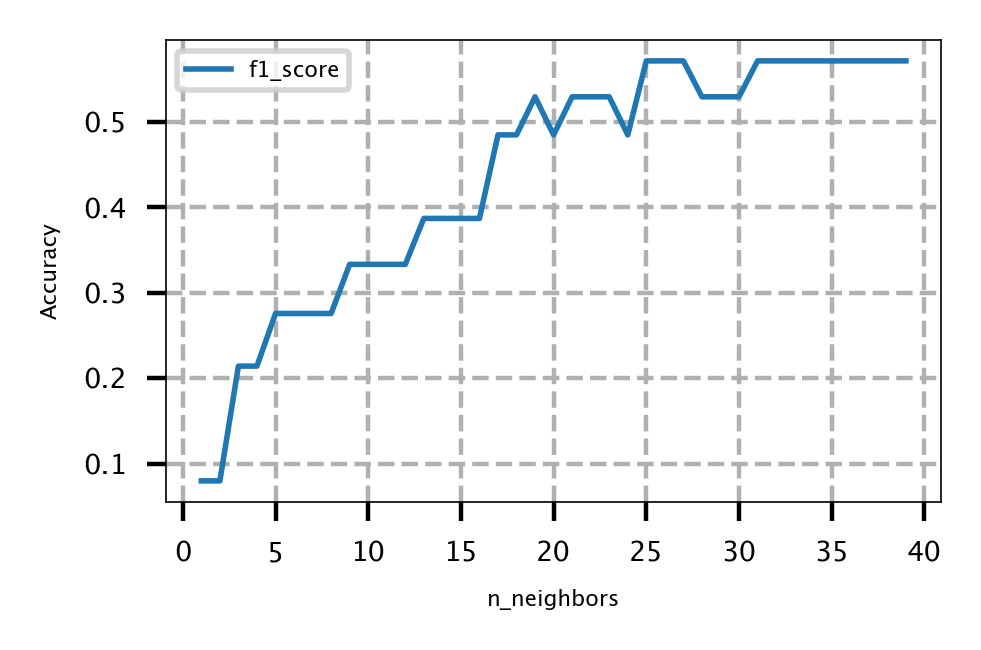

In [500]:
#PLot of train and test accuracy/F1 for different K neighbours
min_neighbours = 1
max_neighbours = 40

training_accuracy_list = []
test_accuracy_list = []
f1_list = []
recall_list = []
number_of_neighbors = range(min_neighbours, max_neighbours)

for neighbor_amount in number_of_neighbors: 
    clf = KNeighborsClassifier(n_neighbors=neighbor_amount)
    clf.fit(X_train_KNN, y_train_KNN)
    training_accuracy_list.append(clf.score(X_train_KNN, y_train_KNN))
    test_accuracy_list.append(clf.score(X_test, y_test))
    y_pred = clf.predict(X_test)
    y_pred = np.round(y_pred)

    f1_list.append(f1_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    #print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))


for numbers in range(min_neighbours-1, max_neighbours-1):
    print(f'f1_score for test set {numbers + 1} neigbor(s): {f1_list[numbers]}')
    print(f'accuracy of test score for {numbers + 1} neigbors(s): {test_accuracy_list[numbers]}')
    print('--')

    
#plt.plot(number_of_neighbors, training_accuracy_list, label='training accuracy', linewidth=1)
#plt.plot(number_of_neighbors, test_accuracy_list, label='test accuracy', linewidth=1)
plt.plot(number_of_neighbors, f1_list, label='f1_score', linewidth=1)
#plt.plot(number_of_neighbors, recall_list, label='recall_score', linewidth=1)
plt.ylabel("Accuracy", fontsize=4)
plt.xlabel("n_neighbors", fontsize=4)
plt.legend(fontsize=4)
plt.grid(linestyle='--')

print(f1_list)

In [505]:

#Prediction
#using k = 2 or maybe also k = 1
from sklearn.neighbors import KNeighborsClassifier 
n_neighbors = 25
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

print(knn.fit(X_train_KNN, y_train_KNN))

#Performance metrics: mean approach and score approach
y_predict_KNN2 = knn.predict(X_test)
print(y_predict_KNN2[0:5])
print(y_test[0:5])

#EM = mean approach ->
accuracy_KNN2 = np.mean(y_predict_KNN2 == y_test)
print(f'Mean Approach for KNN classifier with k = {n_neighbors}:')
print(f'The accuracy is: {accuracy_KNN2:.2f}')
print(f'Score Approach for KNN classifier with k = {n_neighbors}:')
print("The test set R^2: {:.2f}".format(knn.score(X_test, y_test)))

KNeighborsClassifier(n_neighbors=25)
[0 0 0 0 0]
893     0
361     0
1640    0
297     0
196     0
Name: P_HABITABLE, dtype: int64
Mean Approach for KNN classifier with k = 25:
The accuracy is: 0.98
Score Approach for KNN classifier with k = 25:
The test set R^2: 0.98


In [168]:
#confusion matrix function
def generate_confusion_matrix_visualization(matrix, classes, 
                                            normalized=False, 
                                            title='Confusion Matrix', 
                                            color_map=plt.cm.Blues):

    '''
    This function creates a visualization of the confusion matrix.
    If the 'normalized' parameter is set to 'True', the matrix will be normalized.
    '''

    plt.imshow(matrix, interpolation='nearest', cmap=color_map)
    plt.title(title, fontsize=4)
    plt.colorbar()
    class_indices = np.arange(len(classes))
    plt.xticks(class_indices, classes, rotation=45, fontsize=3)
    plt.yticks(class_indices, classes, fontsize=3)

    if normalized:
        matrix = matrix.astype('float')/matrix.sum(axis=1)[:, np.newaxis]
        print('Confusion matrix normalized')
    else:
        print('Confusion matrix not normalized')
    
    print(matrix)
    
    threshold = matrix.max()/2
    for i, j in zip(*np.where(matrix > threshold)):
        plt.text(j, i, matrix[i, j], 
                 horizontalalignment='center', 
                 color='white', fontsize=4)
    for i, j in zip(*np.where(matrix <= threshold)):
        plt.text(j, i, matrix[i, j], 
                 horizontalalignment='center', 
                 color='black', fontsize=4)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=3)
    plt.xlabel('Predicted label', fontsize=3)


Confusion matrix not normalized
[[670   1]
 [ 14  10]]


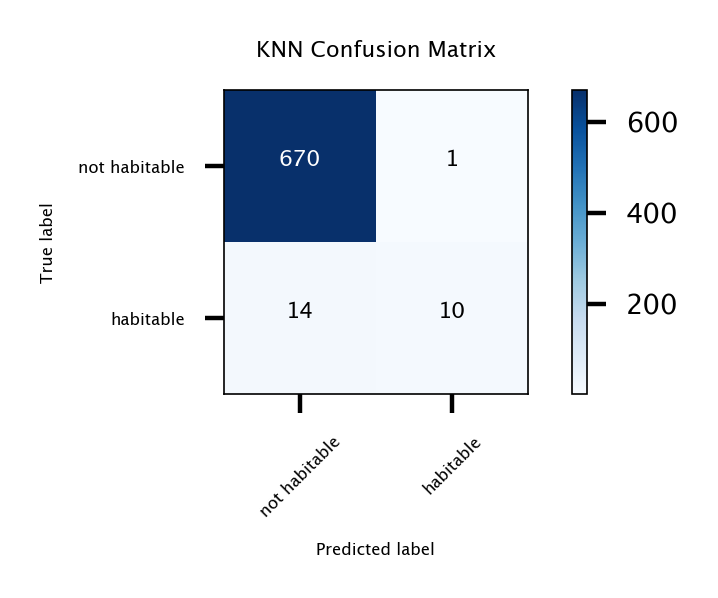

In [506]:
matrix = confusion_matrix(y_true=y_test, y_pred=y_predict_KNN2)

# corresponding labels for 0 and 1
cm_plot_labels = ['not habitable', 'habitable']

# use def function above
generate_confusion_matrix_visualization(matrix=matrix, classes=cm_plot_labels, title='KNN Confusion Matrix')

In [101]:
print("Test set R^2: {:.2f}".format(knn.score(X_test, y_test)))

Test set R^2: 0.98


### $\text{NN CLASSFIFCATON}$

In [177]:
#Declare NN CLASSIFICATION SUBSETS:
#all necesseary subsets:
X_train_NN = fRescaler(df_knn_train).drop('P_HABITABLE', axis = 1)
y_train_NN = df_knn_train['P_HABITABLE']
X_test = X_test[X_train_KNN.columns].reset_index(drop = True)
#X_test.drop('P_HABITABLE', axis=1)
#y_test

In [508]:
#Grid search with the goal of hyperparameter optimization:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#GRID SEARCH IDEA for classification:
# Define a function that creates the Keras model
def create_model(num_layers, num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
    for i in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam',  metrics=[f1_m])
    print(f1_m)
    return model

# Create a KerasRegressor wrapper for GridSearchCV
model = KerasRegressor(build_fn=create_model)

# Define the hyperparameters to search over
param_grid = {'num_layers': [1, 2, 3], 'num_neurons': [32, 64, 128]}

# Create a GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and evaluation metrics
print(f"Best: {grid_result.best_params_}, Score: {grid_result.best_score_:.4f}")

/var/folders/sr/ttxsgn1x77d0_dm9kv1l52l40000gn/T/ipykernel_74269/44630387.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)


<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 596us/step - loss: 1427.3569 - f1_m: 0.0247
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 598us/step - loss: 135520.3125 - f1_m: 0.0135
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 622us/step - loss: 17740.9785 - f1_m: 0.0713
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 604us/step - loss: 91407.1797 - f1_m: 0.0404
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 614us/step - loss: 12713.8896 - f1_m: 0.1839
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 606us/step - loss: 702.3224 - f1_m: 0.0276
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 709us/step - loss: 1105.9321 - f1_m: 0.0000e+00
<function f1_m at 0x2d2302ef0>
9/9 [==============================] - 0s 582us/step - loss: 3413.0059 - f1_m: 0.0692
<function f1_m at 0x2d2302ef0>
9/9 [====================

In [512]:
#Build and run NN best classification model:
#Best: {'num_layers': 3, 'num_neurons': 64}, Score: -71.6431 ...:

model = Sequential()
model.add(Dense(64, input_shape=(11,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_m])
path_model = 'categorical_NN.h5'

# fit the model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=100)
# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
f1_score = model.evaluate(X_test, y_test)

y_predict_NN = model.predict(X_test)
accuracy_NN = np.mean(np.around(y_predict_NN.reshape(y_test.shape)) == y_test)
print('Mean Approach for NN classifier:')
print(f'The accuracy is: {accuracy_NN:.2f}')
test_table = pd.DataFrame([list(y_test[:50]), np.around(list(y_predict_NN.reshape(y_test.shape))[:50])]).T
test_table.columns = ['Actual', 'Predicted']
print('First 25 observations comparison:')
print(test_table)

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 9.9084 - f1_m: 0.0119 - val_loss: 1.4856 - val_f1_m: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 1ms/step - loss: 0.9254 - f1_m: 0.0000e+00 - val_loss: 1.0651 - val_f1_m: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 0s 1ms/step - loss: 0.4990 - f1_m: 0.1613 - val_loss: 0.2617 - val_f1_m: 0.0714
Epoch 4/100
31/31 [==============================] - 0s 1ms/step - loss: 0.1162 - f1_m: 0.1398 - val_loss: 0.2033 - val_f1_m: 0.0714
Epoch 5/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0977 - f1_m: 0.1441 - val_loss: 0.0704 - val_f1_m: 0.2976
Epoch 6/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0656 - f1_m: 0.1720 - val_loss: 0.0663 - val_f1_m: 0.1190
Epoch 7/100
31/31 [==============================] - 0s 1ms/step - loss: 0.0625 - f1_m: 0.2097 - val_loss: 0.0948 - val_f1_m: 0.0714
Epoch 8/100
31/31 [==============================] - 0s 1

Confusion matrix not normalized
[[670   1]
 [  7  17]]


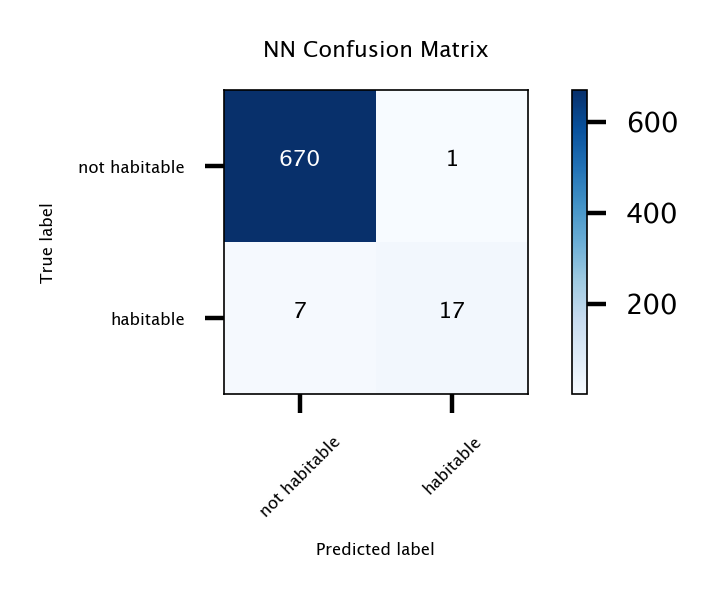

In [513]:
matrix = confusion_matrix(y_true=y_test, y_pred=np.around(y_predict_NN.reshape(y_test.shape)))

# corresponding labels for 0 and 1
cm_plot_labels = ['not habitable', 'habitable']

# use def function above
generate_confusion_matrix_visualization(matrix=matrix, classes=cm_plot_labels, title='NN Confusion Matrix')

## $\text{Numerical Prediction:}$

In [569]:
planet_df_working

,P_RADIUS,P_PERIOD,S_DEC,S_DISTANCE,S_METALLICITY,S_MASS,P_FLUX,P_TYPE,S_ABIO_ZONE,P_HABITABLE,P_MASS_EST,HABZONE,P_ESI
0,1.905700,0.736539,28.330818,12.59,0.31,0.91,2420.618400,3,0.723308,0,8.079188,0,0.259897
1,2.578300,41.685500,20.599232,180.39,-0.15,1.67,14.830572,1,2.357775,0,22.247960,0,0.307962
2,16.702900,1.508956,-3.102147,805.31,-0.30,0.95,2160.722500,0,2.679932,0,327.362840,0,0.055288
3,10.873700,13.240600,0.746143,345.00,0.26,0.89,39.299539,0,0.583211,0,874.027010,0,0.107056
4,16.030300,2.994330,5.937688,560.00,-0.03,1.27,1521.599200,0,6.850910,0,740.539250,0,0.057585
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2.040220,6.267900,-80.469124,18.28,0.08,1.09,307.874350,3,3.257894,0,4.821451,0,0.256979
2100,2.188192,162.870000,-15.937480,3.60,-0.55,0.78,1.613943,4,0.885999,1,3.931532,1,0.737081
2101,1.870000,28.165600,-3.389389,160.00,0.00,0.41,1.402963,3,0.048021,1,4.155456,1,0.755038
2102,1.703920,6.689000,-44.512703,3.69,-0.08,0.12,1.353492,4,0.007807,1,1.750000,1,0.879042


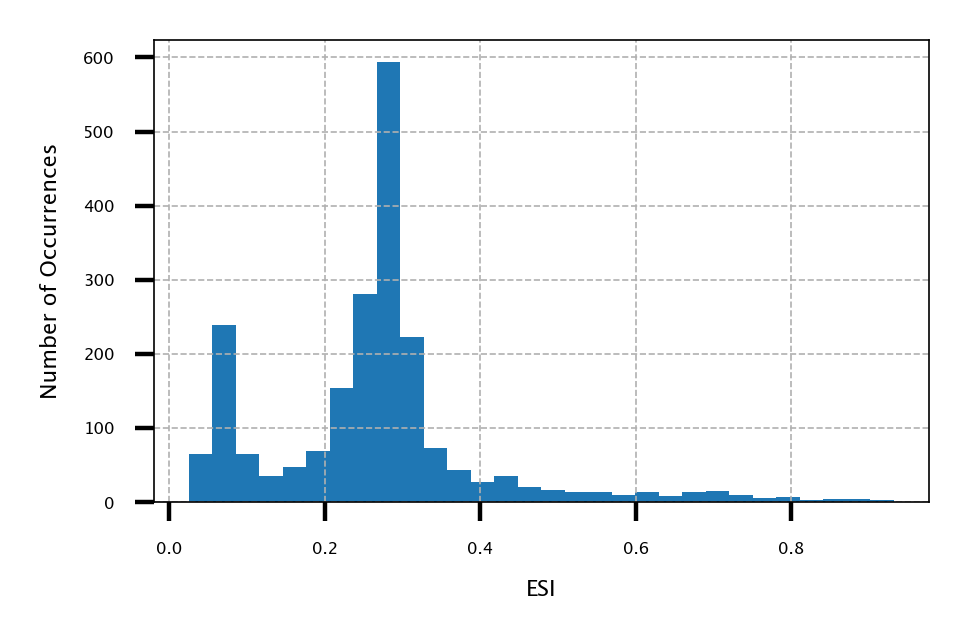

In [568]:
plt.hist(planet_df_working.P_ESI, bins=30)

plt.xlabel('ESI', fontsize=4)
plt.ylabel('Number of Occurrences', fontsize=4)
plt.tick_params(axis='both', labelsize=3)
plt.grid(linewidth=0.3, linestyle = '--')


In [228]:
# neem no coll df, voeg P_ESI toe, split en resample met SMOTE ENN REBALANCING NIET NODIG, rescale met standard/minmax, model + predict

# RESCALING METHOD DEPENDS ON OUTLIERS --> outliers: minmax, no outliers: standard

#SMOTE-ENN resampling method for 

#exclude the column P_HABITABLE for classification problem 
planet_df_working_num = planet_df_working.drop('P_HABITABLE', axis=1)

# Split your data into features (X) and target variable (y)
X_NN = planet_df_working_num.drop('P_ESI', axis=1)
y_NN = planet_df_working_num['P_ESI']

In [229]:
#make sure that categorical variables are of type int64
X_NN.dtypes

P_RADIUS         float64
P_PERIOD         float64
S_DEC            float64
S_DISTANCE       float64
S_METALLICITY    float64
S_MASS           float64
P_FLUX           float64
P_TYPE             int64
S_ABIO_ZONE      float64
P_MASS_EST       float64
HABZONE            int64
dtype: object

In [ ]:
#WHEN USING THE EXTRA LAYERS AS SUGGESTED BY GRID SEARCH AND A DROPOUT RATE/LAYER 
## WITH EXTRA LAYERS + DROPOUT:
# NN MSE: 0.002816028321471762
# NN MAE: 0.017942747073846892

## WITH EXTRA LAYERS + NO DROPOUT: --> LOWEST!
# NN MSE: 0.0012507619272279326
# NN MAE: 0.01631846826871572

## NO EXTRA LAYERS + DROPOUT:
# NN MSE: 0.012521942721951129
# NN MAE: 0.023805326877348133

## NO EXTRA LAYERS + NO DROPOUT:
# NN MSE: 0.03247199361388724
# NN MAE: 0.030722378955349447

In [ ]:

#GRID SEARCH IDEA:
# Define a function that creates the Keras model
def create_model(num_layers, num_neurons):
    model = Sequential()
    model.add(Dense(num_neurons, input_dim=X_train.shape[1], activation='relu'))
    for i in range(num_layers - 1):
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model

# Create a KerasRegressor wrapper for GridSearchCV
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'num_layers': [1, 2, 3, 4, 5], 'num_neurons': [4, 8, 16, 32, 64, 128]}

# Create a GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train, y_train)

# Print the best hyperparameters and evaluation metrics
print(f"Best: {grid_result.best_params_}, Score: {grid_result.best_score_:.4f}")



Epoch 1/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0140 - mean_absolute_error: 0.0797 - val_loss: 0.0047 - val_mean_absolute_error: 0.0393
Epoch 2/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0025 - mean_absolute_error: 0.0338 - val_loss: 0.0019 - val_mean_absolute_error: 0.0275
Epoch 3/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0017 - mean_absolute_error: 0.0269 - val_loss: 0.0020 - val_mean_absolute_error: 0.0286
Epoch 4/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0015 - mean_absolute_error: 0.0252 - val_loss: 0.0015 - val_mean_absolute_error: 0.0230
Epoch 5/100
53/53 [==============================] - 0s 1ms/step - loss: 0.0011 - mean_absolute_error: 0.0207 - val_loss: 0.0015 - val_mean_absolute_error: 0.0240
Epoch 6/100
53/53 [==============================] - 0s 1ms/step - loss: 9.0256e-04 - mean_absolute_error: 0.0188 - val_loss: 0.0012 - val_mean_absolute_error: 0.0198
Epoch 7/100
53/53 

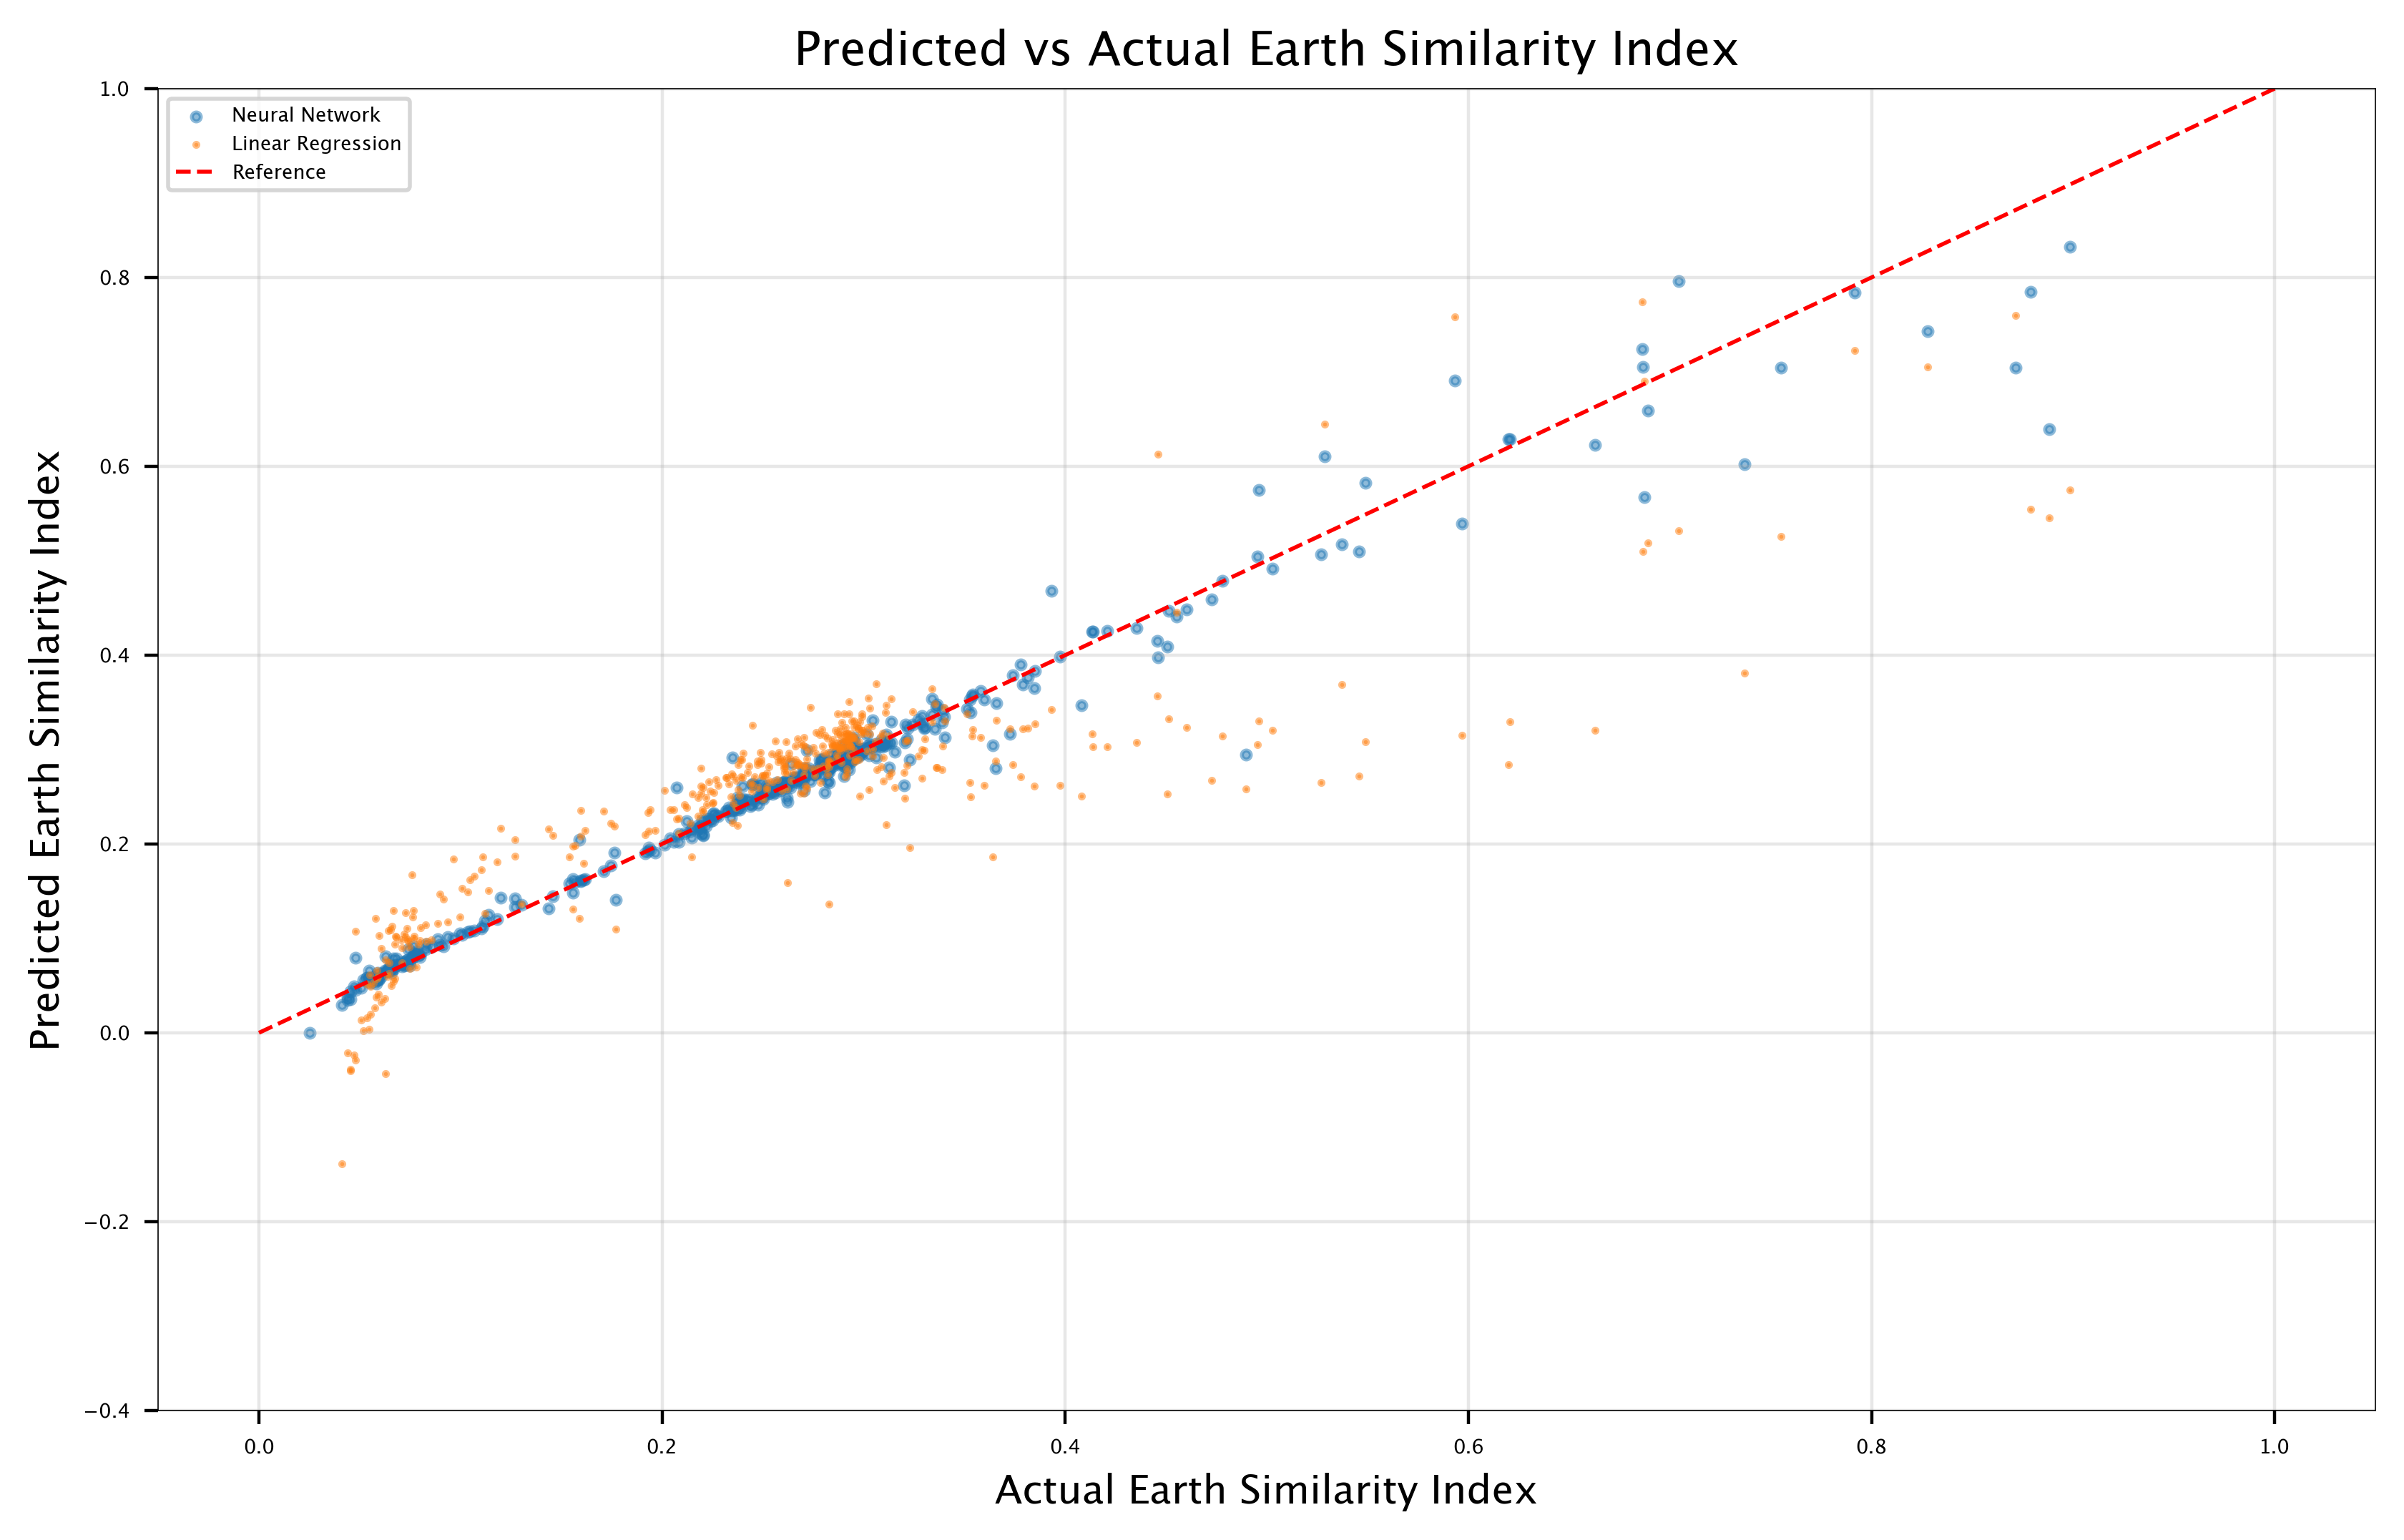

In [592]:
#FULL NN implementation

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(fRescaler(X_NN, scaler = StandardScaler()), 
    y_NN, test_size=0.2, random_state=42)


### NN ###
# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.2, input_shape=(128,)))
#model.add(Dense(128, activation='linear'))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)



### LM ###
# Train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate evaluation metrics for linear regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)




print(f"NN MSE: {mse}")
print(f"NN MAE: {mae}")
print(f"Linear Regression MSE: {mse_lr}")
print(f"Linear Regression MAE: {mae_lr}")

#WITH STANDARDSCALER: 
# MSE: 0.0035190343414775948
# MAE: 0.021133715469169773

#WTH MINMAX SCALING:
# MSE: 0.0017118221118651137
# MAE: 0.0217906191356303

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test[2:], y_pred[2:], s=5, alpha=0.5, label='Neural Network')
plt.scatter(y_test[2:], y_pred_lr[2:], s=1, alpha=0.5, label='Linear Regression')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', linewidth=1, label='Reference')

# Add axis labels and title
plt.xlabel("Actual Earth Similarity Index", fontsize=10)
plt.ylabel("Predicted Earth Similarity Index", fontsize=10)
plt.title("Predicted vs Actual Earth Similarity Index", fontsize=12)

plt.ylim(-0.40, 1)
plt.grid(True, alpha=0.3)
plt.legend(fontsize = 5)

In [243]:
#End script.